# Peak Fitting in Synthetic XRD-CT Datasets

## 📝 Introduction

In this notebook, we explore **peak-based analysis** of synthetic XRD-CT datasets generated using the `nDTomo` package. Having already performed unsupervised analysis (e.g. PCA, NMF, clustering) on this dataset, we now focus on **quantitative extraction of diffraction peak parameters**, which is essential in many real-world applications of XRD-CT.

This step mimics the **final stage of XRD-CT data analysis**, where we move beyond general pattern recognition and into **parametric modelling of Bragg reflections** — enabling phase quantification, strain mapping, and microstructural analysis.

## 🎯 Objectives

By the end of this notebook, you will:
- Re-use the synthetic phantom XRD-CT dataset generated previously
- Perform background subtraction and identify key peaks
- Fit diffraction patterns using both single-peak and multi-peak models
- Generate 2D chemical maps based on extracted peak intensities, positions, or FWHM
- Evaluate the effectiveness of peak fitting on clean, controlled data

## 🧪 Why Peak Fitting?

While clustering and unmixing methods can reveal overall trends, **peak fitting allows you to extract phase-specific parameters** with physical meaning:

- **Peak position** → Lattice parameter / strain
- **Peak area** → Phase abundance
- **Peak width** → Crystallite size or microstrain (via Scherrer or Williamson-Hall)

These metrics are especially valuable in:
- Operando catalyst studies
- Battery material evolution
- Polymorphism detection
- Crystallinity and size analysis

Even in synthetic datasets, peak fitting provides a crucial benchmark to test the limits of resolution and accuracy.

## 📦 Dataset

We will re-use the same synthetic phantom XRD-CT dataset created earlier:

- 5 chemical components (Al, Cu, Fe, Pt, Zn)
- 2D spatial images for each component
- Simulated diffraction patterns for each pixel

The volume has shape:

$$
(x, y, q) = (200, 200, 250)
$$

where $q$ is the diffraction axis (e.g., $2\theta$ or $q$-space).

We now begin by importing the relevant packages and loading the synthetic volume.

## 🧪 Generate the Synthetic XRD-CT Phantom

Before we begin fitting diffraction peaks, we must first simulate a synthetic chemical tomography dataset using `nDTomo`. This dataset mimics the type of data produced in real XRD-CT experiments, where each pixel contains a full diffraction pattern (rather than a single intensity value).

We simulate 5 chemical components (Al, Cu, Fe, Pt, Zn), each defined by:
- A **reference diffraction pattern** (1D)
- A **2D spatial image** showing where the phase is located

These are linearly combined into a 3D dataset of shape $(x, y, q)$, where each spatial pixel has its own composite diffraction pattern.

### 📥 Load Spectra and Spatial Maps

We begin by importing the simulated diffraction patterns and the corresponding phantom images.

Next we generate a 3D synthetic XRD-CT volume by assigning spectra to spatial regions. Each pixel's diffraction pattern is a weighted sum of the reference patterns based on the phase distribution images.


c:\Users\anton\anaconda3\envs\ndtomo\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "
c:\Users\anton\anaconda3\envs\ndtomo\lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\Users\anton\anaconda3\envs\ndtomo\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
c:\Users\anton\anaconda3\envs\ndtomo\lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorith

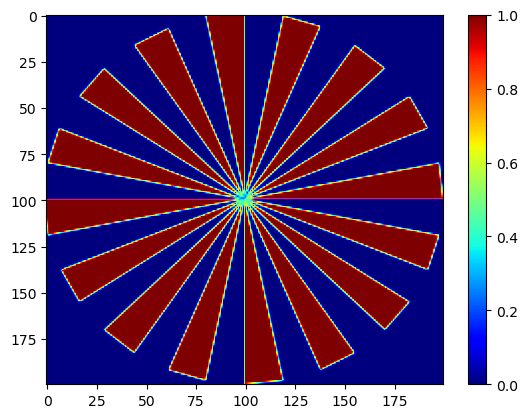

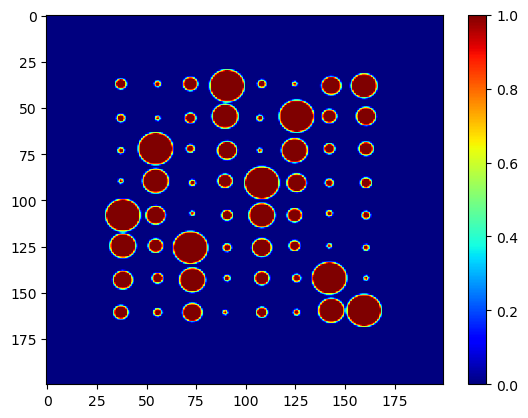

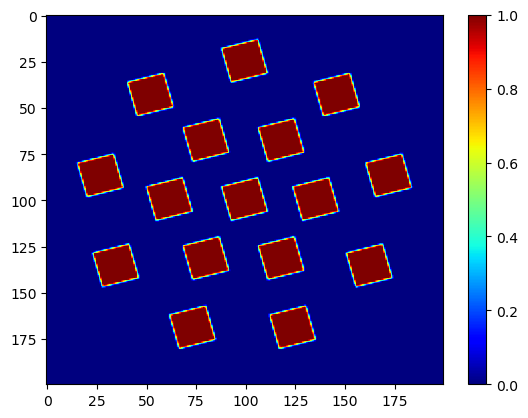

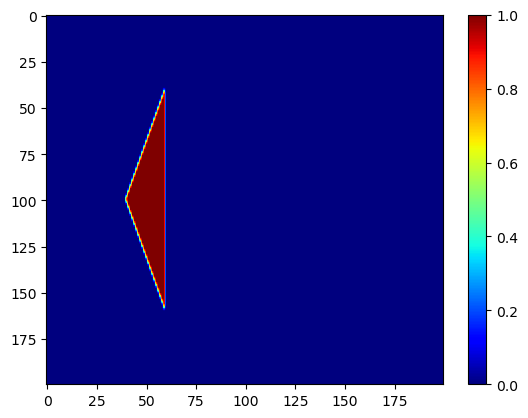

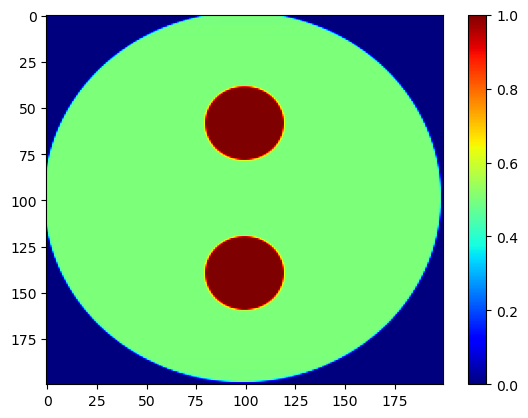

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from nDTomo.sim.phantoms import load_example_patterns, nDTomophantom_2D, nDTomophantom_3D
from nDTomo.methods.plots import showspectra, showim


# Create 2D spatial images for the five components
npix = 200
im1, im2, im3, im4, im5 = nDTomophantom_2D(npix, nim='Multiple')
iml = [im1, im2, im3, im4, im5]

im5 = im5/np.max(im5)

%matplotlib inline

# Optionally display spatial maps
showim(im1, 2)
showim(im2, 3)
showim(im3, 4)
showim(im4, 5)
showim(im5, 6)


In [2]:

def linear_background(x, slope, intercept):
    return slope*x + intercept

def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2*sigma**2))

# Define the x axis
# x = np.arange(0, 5, 0.025)
# x = np.arange(0, 5, 0.075)
x = np.arange(0, 5, 0.1)

# Define the min/max for the various parameters

peak1_mu_min = 2
peak1_mu_max = 3

peak1_sigma_min = 0.2
peak1_sigma_max = 0.4

peak1_A_min = 0
peak1_A_max = 1.25

bkg_slope_min = 0.0
bkg_slope_max = 0.025

bkg_intercept_min = 0.05
bkg_intercept_max = 0.25

im6 = im2 + im5
im6 = im6 / np.max(im6)

peak_area = peak1_A_min + im6*(peak1_A_max - peak1_A_min)
peak_position = peak1_mu_min + im2*(peak1_mu_max - peak1_mu_min)
peak_fwhm = peak1_sigma_min + im3*(peak1_sigma_max - peak1_sigma_min)
peak_slope = bkg_slope_min + im4*(bkg_slope_max - bkg_slope_min)
peak_intercept = bkg_intercept_min + im5*(bkg_intercept_max - bkg_intercept_min)

vol = np.zeros((im1.shape[0], im1.shape[1], len(x)), dtype = 'float32')

mask_tmp = np.copy(peak_area)
mask_tmp[mask_tmp<0.0001] = 0
mask_tmp[mask_tmp>0] = 1

for ii in tqdm(range(im1.shape[0])):
    for jj in range(im1.shape[1]):
        if mask_tmp[ii,jj] > 0:
            vol[ii,jj,:] = gaussian(x, A=peak_area[ii,jj], mu=peak_position[ii,jj], sigma=peak_fwhm[ii,jj]) + \
                           linear_background(x, slope=peak_slope[ii,jj], intercept=peak_intercept[ii,jj])

extra = 20
vol = np.concatenate((np.zeros((vol.shape[0], extra, len(x)), dtype = 'float32'), vol, np.zeros((vol.shape[0], extra, len(x)), dtype = 'float32')), axis=1)
vol = np.concatenate((np.zeros((extra, vol.shape[1], len(x)), dtype = 'float32'), vol, np.zeros((extra, vol.shape[1], len(x)), dtype = 'float32')), axis=0)

print(vol.shape, np.max(vol))


def addpnoise3D(vol, ct):
    '''
    Adds Poisson noise to a 3D hyperspectral volume (H x W x Bands),
    noise is added per pixel-spectrum (i.e., per (i,j,:)).
    
    Parameters
    ----------
    vol : ndarray
        3D hyperspectral image (H x W x Bands), must be non-negative.
    ct : float
        Scaling constant to simulate photon counts.
    '''
    vol = vol.copy()
    mi = np.min(vol)
    if mi < 0:
        vol = vol - mi + np.finfo(np.float32).eps
    elif mi == 0:
        vol = vol + np.finfo(np.float32).eps

    # Apply Poisson noise per pixel-spectrum
    noisy = np.random.poisson(vol * ct) / ct
    return noisy

# vol = vol + 0.001*np.random.rand(vol.shape[0], vol.shape[1], vol.shape[2])
# # vol = addpnoise3D(vol, ct=1000)
vol = addpnoise3D(vol, ct=100)
vol[vol<0] = 0



100%|██████████| 200/200 [00:00<00:00, 532.58it/s]


(240, 240, 50) 1.5


We can now interactively explore the spectral content of this volume using the chemimexplorer

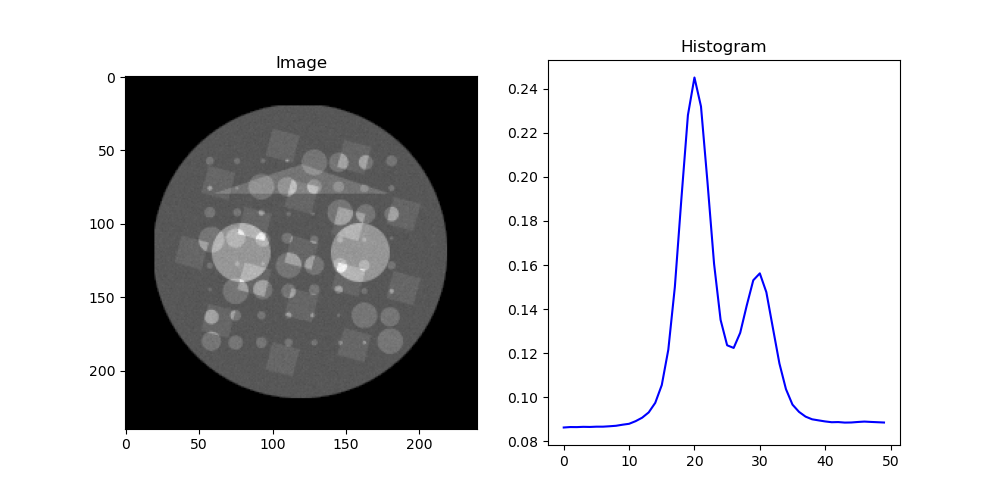

In [3]:
from nDTomo.methods.hyperexpl import chemimexplorer
                
%matplotlib widget
    
# Create an instance of the GUI
gui = chemimexplorer(vol)

In [4]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage import measure
from tqdm import tqdm
import torch
import time
import torch.nn.functional as F
import random
import torch
from torch.quasirandom import SobolEngine
import numpy as np
import torch
import torch.optim as optim
from torch import nn
from torchvision.transforms.functional import rotate
from torchvision.transforms import InterpolationMode
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.transforms.functional import InterpolationMode

from peakcnn.peaks_models import linear_background, gaussian, create_bounds, initial_guesses
from peakcnn.peaks_scipy import fit_spectrum, evaluate_model
from peakcnn.peaks_torch import prepare_prms, PeakModel
from peakcnn.vis import chemimexplorer
from peakcnn.losses import SSIM3D
from peakcnn.utils import calc_indices, calc_patches_indices, denormalize

%matplotlib inline

Using device: cuda


In [5]:

def create_cirmask(npix_im=512, npx=0):

    """
    Create a circular mask for a squared image.

    Args:
        npix_im (int): Size of the squared image (default: 512).
        npx (int): Number of pixels to exclude from the circular mask (default: 0).
    
    Returns:
        numpy.ndarray: A binary circular mask with excluded pixels.
    """
    im = np.ones((npix_im, npix_im), dtype='float32')
    sz = np.floor(im.shape[0])
    x = np.arange(0,sz)
    x = np.tile(x,(int(sz),1))
    y = np.swapaxes(x,0,1)
    xc = np.round(sz/2)
    yc = np.round(sz/2)
    r = np.sqrt(((x-xc)**2 + (y-yc)**2))
    im = np.where(r>np.floor(sz/2) - npx,0,1)
    return(im)

def denormalize(param, param_name, param_min, param_max, peak_number=None):

    """
    Denormalize the parameter from [0, 1] to its original range.
    
    Parameters:
    param (float): The parameter to be denormalized.
    param_name (str): The name of the parameter.
    param_min (dict): A dictionary containing the minimum values of the parameters.
    param_max (dict): A dictionary containing the maximum values of the parameters.
    peak_number (int, optional): The peak number for the parameter. Default is None.
    
    Returns:
    float: The denormalized parameter.
    """
        
    if peak_number is None:  # For Slope and Intercept
        return param_min[param_name] + (param_max[param_name] - param_min[param_name]) * param
    return param_min[param_name][peak_number] + (param_max[param_name][peak_number] - param_min[param_name][peak_number]) * param


def calc_indices(npix_x, npix_y, num_patches, patch_size=32):

    """
    Calculate the indices of the patches to be selected.

    Parameters:
    npix_x (int): The number of pixels in the x direction.
    npix_y (int): The number of pixels in the y direction.
    num_patches (int): The number of patches to be selected.
    patch_size (int, optional): The size of the patches. Default is 32.

    Returns:
    list: A list of tuples containing the starting indices of the selected patches.
    """
        
    selected_indices = []  # Store the indices of selected patches
    # Randomly select patches
    for _ in range(num_patches):
        h_start = torch.randint(0, npix_x - patch_size + 1, size=(1,))
        w_start = torch.randint(0, npix_y - patch_size + 1, size=(1,))
        # Store the starting indices of each patch
        selected_indices.append((h_start.item(), w_start.item()))
    return(selected_indices)
    

def calc_patches_indices(indices, tensor, patch_size, use_middle=False):
    """
    Calculate the indices of the patches to be selected based on the provided indices.
    Users can choose to use the middle of the patch or the top-left as the reference point.
    
    Parameters:
    indices (list of tuples): A list of tuples containing the starting indices of the patches.
    tensor (torch.Tensor): The tensor from which the patches are to be selected.
    patch_size (int): The size of the patches.
    use_middle (bool): If True, use the middle pixel as the reference. If False, use the top-left.
    
    Returns:
    torch.Tensor: A tensor containing the selected patches.
    """
    selected_patches = []
    if use_middle:
        half_patch = int(patch_size / 2)
        for (h_start, w_start) in indices:
            h_center = h_start - half_patch
            w_center = w_start - half_patch
            patch = tensor[..., h_center:h_center + patch_size, w_center:w_center + patch_size]
            selected_patches.append(patch)
    else:
        for (h_start, w_start) in indices:
            patch = tensor[..., h_start:h_start + patch_size, w_start:w_start + patch_size]
            selected_patches.append(patch)

    # Concatenate patches for processing
    return torch.cat(selected_patches, dim=0)


def generate_sobol_indices_batch(rows, cols, batch_size, patch_size, device):
    """
    Generate a batch of Sobol indices for a given dimension and batch size, considering the patch size to avoid boundary issues.
    
    Parameters:
    rows (int): The total number of rows in the dataset.
    cols (int): The total number of columns in the dataset.
    batch_size (int): The number of indices to generate.
    patch_size (int): The size of the patch to consider for boundary adjustment.
    device (torch.device): The device to use for generating indices.
    
    Returns:
    tuple: Two tensors containing the row indices and column indices.
    """
    sobol = SobolEngine(dimension=2, scramble=True)

    # Define the range for indices to avoid boundary issues
    max_row = rows - patch_size
    max_col = cols - patch_size

    # Generate indices on the CPU
    points = sobol.draw(batch_size)
    
    # Move the generated points to the specified device and scale them
    points = points.to(device) * torch.tensor([max_row, max_col], device=device, dtype=torch.float32)
    points = points.int()

    return points[:, 0], points[:, 1]


def generate_indices(rows, cols, num_indices, patch_size, distribution_type='uniform', std=3, mask=None, device='cuda', batched=False):
    mean_row = float(rows) / 2
    mean_col = float(cols) / 2
    indices = []
    
    while len(indices) < num_indices:
        batch_size = num_indices - len(indices) if batched else 1

        if distribution_type == 'normal':
            sample_rows = torch.normal(mean=torch.full((batch_size,), mean_row, dtype=torch.float32, device=device),
                                       std=torch.full((batch_size,), std, dtype=torch.float32, device=device)).round().int()
            sample_cols = torch.normal(mean=torch.full((batch_size,), mean_col, dtype=torch.float32, device=device),
                                       std=torch.full((batch_size,), std, dtype=torch.float32, device=device)).round().int()
        elif distribution_type == 'uniform':
            sample_rows = torch.randint(0, rows, (batch_size,), device=device)
            sample_cols = torch.randint(0, cols, (batch_size,), device=device)
        elif distribution_type == 'Sobol':
            sample_rows, sample_cols = generate_sobol_indices_batch(rows, cols, batch_size, patch_size, device)
        else:
            raise ValueError("Invalid distribution type specified. Choose 'normal', 'uniform', or 'Sobol'.")

        sample_rows = sample_rows.long()  # Ensure indices are long for masking
        sample_cols = sample_cols.long()

        # Validate indices within range
        valid = (sample_rows >= 0) & (sample_rows < rows) & (sample_cols >= 0) & (sample_cols < cols)

        # Apply mask if available and ensure indices are used for mask access are already validated
        if mask is not None and valid.any():
            valid_indices = valid.nonzero(as_tuple=True)
            valid_mask = mask[sample_rows[valid_indices], sample_cols[valid_indices]]
            # Refine valid to include only those indices where mask is true
            valid[valid_indices] = valid_mask

        # Collect valid indices
        valid_sample_rows = sample_rows[valid]
        valid_sample_cols = sample_cols[valid]

        indices.extend(zip(valid_sample_rows.tolist(), valid_sample_cols.tolist()))
        if len(indices) >= num_indices:
            indices = indices[:num_indices]  # Ensure we do not exceed the number of requested indices

    return indices


def initialize_counter(rows, cols):
    """
    Initialize a zero-filled counter matrix of the same size as the input matrix using PyTorch.
    
    Parameters:
    - matrix (2D torch tensor): Matrix whose dimensions will be used to create the counter.
    
    Returns:
    - 2D torch tensor: Initialized counter matrix.
    """
    return torch.zeros((rows, cols), dtype=torch.float32)

def update_counter(counter, indices, patch_size=(1, 1)):
    """
    Update the pixel utilization counter based on the middle indices of extracted patches or pixels using PyTorch.
    
    Parameters:
    - counter (2D torch tensor): Counter matrix to be updated.
    - indices (list of tuples): Indices of the top-left corners of the patches or pixels.
    - patch_size (tuple): Size (height, width) of the patches or single pixel (default is 1x1 for pixels).
    """
    patch_rows, patch_cols = patch_size
    for r, c in indices:
        # counter[r - int(patch_rows/2):r + int(patch_rows/2), c - int(patch_cols/2):c + int(patch_cols/2)] += 1
        counter[r:r + int(patch_rows), c :c + int(patch_cols)] += 1


def sample_and_count(rows, cols, num_indices, num_iterations, patch_size, distribution_type,
                     batched=False, std_dev=None, mask=None, device='cuda'):
    """
    Repeatedly sample indices, update the utilization counter for patches or single pixels for a specified number of iterations.
    
    Parameters:
    - rows (int): The rows of the matrix.
    - cols (int): The columns of the matrix.
    - num_indices (int): Number of indices per iteration.
    - num_iterations (int): Number of sampling iterations.
    - patch_size (int): Size of each patch (square) if use_patches is True, otherwise 1 for single pixels.
    - distribution_type (str): 'normal' or 'uniform' for distribution type.
    - use_gpu (bool): Flag to use GPU if available.
    - use_patches (bool): Flag to decide between using patches or single pixels.
    
    Returns:
    - 2D torch tensor: Counter matrix showing pixel utilization.
    """
    counter = initialize_counter(rows, cols)
    patch_dimensions = (patch_size, patch_size)

    for _ in range(num_iterations):
        indices = draw_valid_indices(rows, cols, num_indices, patch_size, distribution_type, batched,
                                     std_dev=std_dev, mask=mask, device=device)      
        update_counter(counter, indices, patch_dimensions)

    return counter

def draw_valid_indices(rows, cols, num_indices, patch_size, distribution_type='normal', 
                       batched=False, std_dev=3, mask=None, device='cuda'):

    """
    Draw valid indices from a specified distribution.
    
    Parameters:
    rows (int): The total number of rows.
    cols (int): The total number of columns.
    num_indices (int): The number of indices to draw.
    patch_size (int): The size of the square patch.
    distribution_type (str): The type of distribution to draw from ('normal', 'uniform' or 'Sobol').
    std_dev (float): The standard deviation for the normal distribution.
    mask (torch.Tensor): A mask to apply to the indices.
    device (torch.device): The device on which to generate the indices.
    
    Returns:
    list: A list of valid indices.
    """
    
    if distribution_type == 'normal' and std_dev is None:
        largest_dimension = max(rows, cols)
        std_dev = largest_dimension / 3  # 3 sigma to span the largest dimension
    indices = generate_indices(rows, cols, num_indices, patch_size, distribution_type=distribution_type, 
                               std=std_dev, mask=mask, device=device, batched=batched)
    return indices


def generate_indices_rmse_map(global_rmse_map, rows, cols, num_indices, patch_size, mask=None, device='cuda', batched=True, method='highest'):
    indices = []
    while len(indices) < num_indices:
        batch_size = num_indices - len(indices) if batched else 1

        if global_rmse_map is not None:
            if method == 'stochastic':
                # Stochastic sampling based on normalized RMSE values
                weights = global_rmse_map.flatten()
                weights = (weights - weights.min()) / (weights.max() - weights.min())
                indices_flat = torch.multinomial(weights, batch_size, replacement=True)
            elif method == 'highest':
                # Deterministic selection based on highest RMSE values
                flat_rmse_map = global_rmse_map.flatten()
                _, sorted_indices = torch.sort(flat_rmse_map, descending=True)
                indices_flat = sorted_indices[:batch_size]  # Take top batch_size indices

            sample_rows = (indices_flat // cols).clamp(min=patch_size // 2, max=rows - patch_size // 2 - 1)
            sample_cols = (indices_flat % cols).clamp(min=patch_size // 2, max=cols - patch_size // 2 - 1)
        else:
            # Fallback if no RMSE map is provided: random sampling
            sample_rows = torch.randint(patch_size // 2, rows - patch_size // 2, (batch_size,), device=device)
            sample_cols = torch.randint(patch_size // 2, cols - patch_size // 2, (batch_size,), device=device)

        sample_rows = sample_rows.long()
        sample_cols = sample_cols.long()
        valid = (sample_rows >= patch_size // 2) & (sample_rows < rows - patch_size // 2) & \
                (sample_cols >= patch_size // 2) & (sample_cols < cols - patch_size // 2)

        # Apply mask if available and ensure indices are used for mask access are already validated
        if mask is not None and valid.any():
            valid_indices = valid.nonzero(as_tuple=True)
            valid_mask = mask[sample_rows[valid_indices], sample_cols[valid_indices]]
            # Refine valid to include only those indices where mask is true
            valid[valid_indices] = valid_mask

        # Collect valid indices
        valid_sample_rows = sample_rows[valid]
        valid_sample_cols = sample_cols[valid]
        indices.extend(zip(valid_sample_rows.tolist(), valid_sample_cols.tolist()))
        if len(indices) >= num_indices:
            indices = indices[:num_indices]  # Ensure we do not exceed the number of requested indices

    return indices


def pad_and_filter_patch_indices(tensor, mask, patch_size):
    # Get dimensions of tensor and mask
    h, w, c = tensor.shape
    
    # Calculate necessary padding for height and width
    pad_height = (patch_size - h % patch_size) % patch_size
    pad_width = (patch_size - w % patch_size) % patch_size

    # Pad tensor and mask to make them evenly divisible by patch_size
    padded_tensor = F.pad(tensor, (0, 0, 0, pad_width, 0, pad_height), mode='constant', value=0)
    padded_mask = F.pad(mask, (0, pad_width, 0, pad_height), mode='constant', value=0)

    # Generate indices for patches, filtering based on mask
    patch_indices = []
    for i in range(0, padded_tensor.shape[0], patch_size):
        for j in range(0, padded_tensor.shape[1], patch_size):
            mask_patch = padded_mask[i:i + patch_size, j:j + patch_size]
            # Check if the mask patch is all zeros
            if not torch.all(mask_patch == 0):
                patch_indices.append((i, j))

    # Shuffle the indices randomly
    if patch_indices:  # Check if list is not empty
        idx_shuffle = torch.randperm(len(patch_indices))
        patch_indices = [patch_indices[i] for i in idx_shuffle]

    return padded_tensor, patch_indices

def pad_mask(mask, patch_size):
    # Determine the necessary padding for height and width
    h, w = mask.shape
    pad_height = (patch_size - h % patch_size) % patch_size
    pad_width = (patch_size - w % patch_size) % patch_size

    # Pad the mask
    padded_mask = F.pad(mask, (0, pad_width, 0, pad_height), mode='constant', value=0)
    return padded_mask

def create_padded_binary_tensor_from_indices(mask, indices, patch_size):
    # Determine the necessary padding for height and width
    h, w = mask.shape
    pad_height = (patch_size - h % patch_size) % patch_size
    pad_width = (patch_size - w % patch_size) % patch_size

    # Pad the mask
    padded_mask = F.pad(mask, (0, pad_width, 0, pad_height), mode='constant', value=0)
    padded_mask_shape = padded_mask.shape

    # Create an empty binary tensor of the same size as the padded mask
    binary_tensor = torch.zeros(padded_mask_shape)

    # Set the patches corresponding to the indices to one
    for (start_i, start_j) in indices:
        binary_tensor[start_i:start_i + patch_size, start_j:start_j + patch_size] = 1
    
    return binary_tensor

def filter_patch_indices(mask, patch_size):
    # Generate indices for patches, filtering based on mask
    patch_indices = []
    for i in range(0, mask.shape[0], patch_size):
        for j in range(0, mask.shape[1], patch_size):
            mask_patch = mask[i:i + patch_size, j:j + patch_size]
            # Check if the mask patch is all zeros
            if not torch.all(mask_patch == 0):
                patch_indices.append((i, j))

    # Shuffle the indices randomly
    if patch_indices:  # Check if list is not empty
        idx_shuffle = torch.randperm(len(patch_indices))
        patch_indices = [patch_indices[i] for i in idx_shuffle]

    return patch_indices


def create_binary_tensor_from_indices(mask, indices, patch_size):

    mask_shape = mask.shape

    # Create an empty binary tensor of the same size as the padded mask
    binary_tensor = torch.zeros(mask_shape)

    # Set the patches corresponding to the indices to one
    for (start_i, start_j) in indices:
        binary_tensor[start_i:start_i + patch_size, start_j:start_j + patch_size] = 1
    
    return binary_tensor


(304, 304, 50) (240, 240, 50) (304, 304)


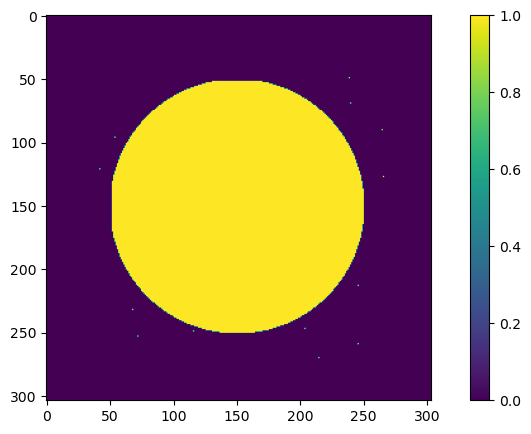

Percentage of pixels probed during one epoch: 51.650326282273575
Number of iterations required to probe full image: 2
The number of patches is  48
The number of iterations (batches) required to probe the whole image is  3
tensor(1.)


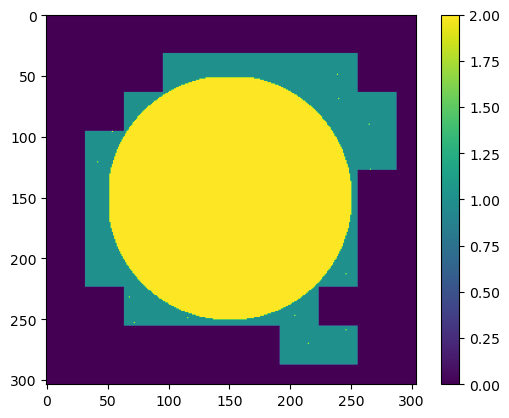

In [6]:
%matplotlib inline

num_iterations = 100
distribution_type = 'uniform'
std_dev = int(vol.shape[0] / 1)
device = 'cuda'
patch_size = 32
num_patches = 16
num_patches_total = 16


mask = np.copy(np.sum(vol,axis=2))
mask[mask>0] = 1
mask = np.concatenate((np.zeros((patch_size, mask.shape[1]), dtype='float32'), mask, np.zeros((patch_size, mask.shape[1]), dtype='float32')), axis = 0)
mask = np.concatenate((np.zeros((mask.shape[0], patch_size), dtype='float32'), mask, np.zeros((mask.shape[0], patch_size), dtype='float32')), axis = 1)

volp = np.copy(vol)
volp = np.concatenate((np.zeros((patch_size, volp.shape[1], volp.shape[2]), dtype='float32'), volp, np.zeros((patch_size, volp.shape[1], volp.shape[2]), dtype='float32')), axis = 0)
volp = np.concatenate((np.zeros((volp.shape[0], patch_size, volp.shape[2]), dtype='float32'), volp, np.zeros((volp.shape[0], patch_size, volp.shape[2]), dtype='float32')), axis = 1)
rows, cols = volp.shape[0], volp.shape[1]  # Size of the matrix
print(volp.shape, vol.shape, mask.shape)

plt.figure(1);plt.clf()
plt.imshow(mask)
plt.colorbar()
plt.show()

npix = np.sum(mask)
pcr_probed = 100* (patch_size*patch_size*num_patches)/npix
print(f"Percentage of pixels probed during one epoch: {pcr_probed}")
niters_required = int(np.ceil(100/pcr_probed))
print(f"Number of iterations required to probe full image: {niters_required}")

mask_t = torch.tensor(mask, dtype=torch.bool, device=device)

# mask = np.copy(imb)
# mask[mask>0] = 1
# mask = np.concatenate((np.zeros((patch_size, mask.shape[1]), dtype='float32'), mask, np.zeros((patch_size, mask.shape[1]), dtype='float32')), axis = 0)
# mask = np.concatenate((np.zeros((mask.shape[0], patch_size), dtype='float32'), mask, np.zeros((mask.shape[0], patch_size), dtype='float32')), axis = 1)


indices = filter_patch_indices(torch.tensor(mask), patch_size)
# indices = generate_indices(rows, cols, 250, patch_size, distribution_type, std=std_dev, mask=mask_t, 
#                     device='cuda', batched=True)
# indices = draw_valid_indices(rows, cols, num_patches_total, patch_size, distribution_type='uniform', 
#                        batched=False, mask=mask_t, device='cuda')
print('The number of patches is ', len(indices))
print('The number of iterations (batches) required to probe the whole image is ', int(len(indices)/num_patches) )


# counter = create_binary_tensor_from_indices(torch.tensor(mask), indices, patch_size)
# counter = counter.numpy()
# print(counter.shape, len(indices))

counter = initialize_counter(rows, cols)
patch_dimensions = (patch_size, patch_size)
update_counter(counter, indices, patch_dimensions)

print(counter.max())

# counter = sample_and_count(rows, cols, num_patches, num_iterations, patch_size, distribution_type,
#                      batched=True, std_dev=std_dev, mask=mask_t, device=device)
counter = counter.numpy()


plt.figure(2);plt.clf()
# plt.imshow(counter * mask )
plt.imshow(counter + mask)
# plt.clim(0,1)
plt.colorbar()
plt.show()


In [7]:

class CNN2D_superres(nn.Module):
    def __init__(self, nch_in=1, nch_out=1, nfilts=32, upscale_factor = 4,
                 norm_type='instance', activation='Linear', padding='same'):
        super(CNN2D_superres, self).__init__()

        self.upscale_factor = upscale_factor
        # Initial feature extraction
        self.input = nn.Conv2d(nch_in, nfilts, kernel_size=3, stride=1, padding=padding, bias=True)

        layers = []
        layers.append(nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False))
        layers.append(nn.Conv2d(nfilts, nfilts, kernel_size=3, stride=1, padding=padding, bias=True))
        # Add normalization based on norm_type
        if norm_type == "instance":
            layers.append(nn.InstanceNorm2d(nfilts, affine=True))
        elif norm_type == "batch":
            layers.append(nn.BatchNorm2d(nfilts))
        # Add activation function
        layers.append(nn.ReLU(inplace=True))

        # layers.append(nn.Conv2d(nfilts, nfilts, kernel_size=3, stride=1, padding=padding, bias=True))
        # # Add normalization based on norm_type
        # if norm_type == "instance":
        #     layers.append(nn.InstanceNorm2d(nfilts, affine=True))
        # elif norm_type == "batch":
        #     layers.append(nn.BatchNorm2d(nfilts))
        # # Add activation function
        # layers.append(nn.ReLU(inplace=True))

        self.upsample1 = nn.Sequential(*layers)

        if self.upscale_factor == 4:
            layers = []
            layers.append(nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False))
            layers.append(nn.Conv2d(nfilts, nfilts, kernel_size=3, stride=1, padding=padding, bias=True))
            # Add normalization based on norm_type
            if norm_type == "instance":
                layers.append(nn.InstanceNorm2d(nfilts, affine=True))
            elif norm_type == "batch":
                layers.append(nn.BatchNorm2d(nfilts))
            # Add activation function
            layers.append(nn.ReLU(inplace=True))

            # layers.append(nn.Conv2d(nfilts, nfilts, kernel_size=3, stride=1, padding=padding, bias=True))
            # # Add normalization based on norm_type
            # if norm_type == "instance":
            #     layers.append(nn.InstanceNorm2d(nfilts, affine=True))
            # elif norm_type == "batch":
            #     layers.append(nn.BatchNorm2d(nfilts))
            # # Add activation function
            # layers.append(nn.ReLU(inplace=True))

            self.upsample2 = nn.Sequential(*layers)

        # Final output layer
        self.xrdct = nn.Conv2d(nfilts, nch_out, kernel_size=3, stride=1, padding=padding, bias=True)

        # Final activation
        self.final_activation = None
        if activation == "ReLU":
            self.final_activation = nn.ReLU()
        elif activation == "Sigmoid":
            self.final_activation = nn.Sigmoid()
        elif activation == "LeakyReLU":
            self.final_activation = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):  # Feature maps from autoencoder2D are passed

        x = self.input(x)

        # Upsampling 1
        x = self.upsample1(x)

        if self.upscale_factor == 4:
            # Upsampling 2
            x = self.upsample2(x)

        # Output layer
        x = self.xrdct(x)

        if self.final_activation is not None:
            x = self.final_activation(x)

        return x
    

class CNN2D(nn.Module):
    def __init__(self, npix, nch_in=1, nch_out=1, nfilts=32, nlayers=4, norm_type='layer', 
                 prms_layer=True, cnn_layer=True, tensor_vals = 'random', tensor_initial = None,
                 padding='same'):
        super(CNN2D, self).__init__()
        self.npix = npix
        self.prms_layer = prms_layer
        self.cnn_layer = cnn_layer

        if self.prms_layer:
            if tensor_vals == 'random':
                self.initial_tensor = nn.Parameter(2*torch.randn(1, nch_in, npix, npix)-1)
            elif tensor_vals == 'zeros':
                self.initial_tensor = nn.Parameter(torch.zeros(1, nch_in, npix, npix))
            elif tensor_vals == 'ones':
                self.initial_tensor = nn.Parameter(torch.ones(1, nch_in, npix, npix))
            elif tensor_vals == 'mean':
                self.initial_tensor = nn.Parameter(0.5*torch.ones(1, nch_in, npix, npix))
            elif tensor_vals == 'random_positive':
                self.initial_tensor = nn.Parameter(torch.randn(1, nch_in, npix, npix))
            elif tensor_vals == 'custom':
                try:
                    self.initial_tensor = nn.Parameter(tensor_initial)
                except:
                    print('Custom tensor not provided. Using random tensor instead')
                    self.initial_tensor = nn.Parameter(torch.randn(1, nch_in, npix, npix))
        if self.cnn_layer:
            layers = []
            layers.append(nn.Conv2d(nch_in, nfilts, kernel_size=3, stride=1, padding=padding))  # 'same' padding in PyTorch is usually done by manually specifying the padding
            if norm_type=='layer':
                if padding=='valid':
                    layers.append(nn.LayerNorm([nfilts, self.npix -2, self.npix -2]))
                else:
                    layers.append(nn.LayerNorm([nfilts, self.npix, self.npix]))
            elif norm_type=='instance':
                layers.append(nn.InstanceNorm2d(nfilts, affine = True))
            elif norm_type=='batchnorm':            
                layers.append(nn.BatchNorm2d(nfilts))

            layers.append(nn.ReLU())

            for layer in range(nlayers):
                
                layers.append(nn.Conv2d(nfilts, nfilts, kernel_size=3, stride=1, padding=padding))
                if norm_type=='layer':
                    if padding=='valid':
                        layers.append(nn.LayerNorm([nfilts, self.npix -2*(layer + 2), self.npix -2*(layer + 2)]))
                    else:
                        layers.append(nn.LayerNorm([nfilts, self.npix, self.npix]))
                elif norm_type=='instance':
                    layers.append(nn.InstanceNorm2d(nfilts, affine = True))            
                elif norm_type=='batchnorm':            
                    layers.append(nn.BatchNorm2d(nfilts))

                layers.append(nn.ReLU())

            layers.append(nn.Conv2d(nfilts, nch_out, kernel_size=3, stride=1, padding=padding))
            layers.append(nn.Sigmoid())
            self.cnn2d = nn.Sequential(*layers)

    def forward(self, x):
        if self.prms_layer and self.cnn_layer:
            out = self.cnn2d(torch.sigmoid(self.initial_tensor))
        elif self.cnn_layer and not self.prms_layer:
            out = self.cnn2d(x)
        elif self.prms_layer and not self.cnn_layer:
            out = torch.sigmoid(self.initial_tensor)
        return out
    

npix_x = volp.shape[0]
npix_y = volp.shape[1]
xv = torch.tensor(x, dtype=torch.float32, device='cuda')


### Single peak
peak_definitions = [(1, 1.0, 4.0)]

num_peaks = len(peak_definitions)
num_params_per_peak = 3  # Area, Position, FWHM
background_params = 2  # Slope, Intercept
total_params = num_peaks * num_params_per_peak + background_params

npix = volp.shape[0]
nch_in = total_params
nch_out = total_params
nfilts = 2*total_params # 2*total_params is pretty good when using norm layer
norm_type='layer'
activation='Sigmoid'
downsampling = 8
device = 'cuda'


model = CNN2D(npix, nch_in=nch_in, nch_out=nch_out, nfilts=nfilts, nlayers=1, norm_type='None', prms_layer=True, cnn_layer=False, tensor_vals = 'zeros').to(device)
model_prms = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of parameters: {model_prms}")
print("Conventional number of parameters:", npix*npix*total_params)

# model_cnn = CNN2D(patch_size + 6, nch_in=volp.shape[2], nch_out=nch_out, nfilts=128, nlayers=1, norm_type='layer', 
#               prms_layer=False, cnn_layer=True, tensor_vals = 'random', padding='valid').to(device)


# model_cnn = CNN2D_superres(nch_in=volp.shape[2], nch_out=nch_out, nfilts=32,  upscale_factor = 4, norm_type='instance', 
#               activation='Sigmoid', padding='same').to(device)



# nch_in = volp.shape[2]
# nfilts = volp.shape[2] # 2*total_params
# model = CNN2D(npix, nch_in=nch_in, nch_out=nch_out, nfilts=nfilts, nlayers=2, norm_type='instance', prms_layer=False, cnn_layer=True, tensor_vals = 'random').to(device)

# # Calculate the total number of parameters
# model_prms = sum(p.numel() for p in model_cnn.parameters() if p.requires_grad)
# print(f"Total number of parameters: {model_prms}")

# print('Number of filters:', nfilts)
# print(nch_out)

# print("Conventional number of parameters:", npix*npix*total_params)

# patch_size_small = 16
# tmp = torch.randn(1, volp.shape[2], patch_size_small, patch_size_small).to(device)
# print(tmp.shape)
# tmp = model_cnn(tmp)
# print(tmp.shape, patch_size_small, patch_size_small*4, patch_size_small*4 - tmp.shape[2])

# yobs = np.transpose(volp, (2,1,0))
# yobs = torch.tensor(yobs, dtype=torch.float32, device=device)
# yobs = torch.reshape(yobs, (1, yobs.shape[0], yobs.shape[1], yobs.shape[2]))
# yobs = torch.transpose(yobs, 3, 2)
# downsampled = F.interpolate(yobs, scale_factor=1/4, mode='bilinear', align_corners=False)
# print(downsampled.shape, yobs.shape, yobs.shape[2]/4)


# upscaled = model_cnn(downsampled)
# print(upscaled.shape, downsampled.shape, yobs.shape)

# ofs = (yobs.shape[2] - upscaled.shape[2]) // 2
# upscaled = torch.concatenate((torch.zeros((1, upscaled.shape[1], ofs, upscaled.shape[3]), dtype=torch.float32).to(device), 
#                            upscaled, 
#                            torch.zeros((1, upscaled.shape[1], ofs, upscaled.shape[3]), dtype=torch.float32).to(device)), axis = 2)
# upscaled = torch.concatenate((torch.zeros((1, upscaled.shape[1], upscaled.shape[2], ofs), dtype=torch.float32).to(device),
#                            upscaled, 
#                            torch.zeros((1, upscaled.shape[1], upscaled.shape[2], ofs), dtype=torch.float32).to(device)), axis = 3)

# sim = upscaled[0,0,:,:]
# sim = sim.cpu().detach().numpy()
# print(sim.shape)
# plt.figure(3);plt.clf()
# plt.imshow(sim)
# plt.colorbar()
# # plt.clim(0.5, 0.53)
# plt.show()


Total number of parameters: 462080
Conventional number of parameters: 462080


In [8]:
def gaussian(x, area, position, fwhm):
    """Gaussian peak shape."""
    return area * torch.exp(-(x - position)**2 / (2 * fwhm**2))
    
MAE = torch.nn.L1Loss()


### Single peak ###
param_min = {
    'Area': torch.zeros(num_peaks, dtype=torch.float32).to(device),
    'Position': torch.tensor([peak[1] for peak in peak_definitions], dtype=torch.float32).to(device),
    'FWHM': torch.zeros(num_peaks, dtype=torch.float32).to(device) + 0.1,
    'Fraction': torch.zeros(num_peaks, dtype=torch.float32).to(device),
    'Slope': torch.zeros(1, dtype=torch.float32).to(device),
    'Intercept': torch.zeros(1, dtype=torch.float32).to(device),
}
param_max = {
    'Area': torch.zeros(num_peaks, dtype=torch.float32).to(device) + 2,
    'Position': torch.tensor([peak[2] for peak in peak_definitions], dtype=torch.float32).to(device),
    'FWHM': torch.zeros(num_peaks, dtype=torch.float32).to(device) + 0.5,
    'Fraction': torch.zeros(num_peaks, dtype=torch.float32).to(device) + 1,
    'Slope': torch.zeros(1, dtype=torch.float32).to(device) + 0.2,
    'Intercept': torch.zeros(1, dtype=torch.float32).to(device) + 0.5,
}    


# bkg_slope_min = -0.01
# bkg_slope_max = 0.01
# bkg_intercept_min = 0.05
# bkg_intercept_max = 0.25

nch = volp.shape[2]
learning_rate = 0.001
epochs = 10000
min_lr = 1E-5

# rand_static = torch.randn(1, nch_in, npix, npix).to(device)
im_static = np.sum(volp, axis=2)
im_static = im_static/np.max(im_static)
im_static = np.reshape(im_static, (1, 1, volp.shape[1], volp.shape[1]))
im_static = torch.tensor(im_static, dtype=torch.float32, device=device)

yobs = np.transpose(volp, (2,1,0))
yobs = torch.tensor(yobs, dtype=torch.float32, device=device)
yobs = torch.reshape(yobs, (1, yobs.shape[0], yobs.shape[1], yobs.shape[2]))
yobs = torch.transpose(yobs, 3, 2)

with torch.no_grad():
    yprms = model(im_static)
    yprms = F.interpolate(yprms, scale_factor=1/4, mode='bilinear', align_corners=False)


##### This is using predefined indices #####

epochs = 50000
patience = 100 #250
learning_rate = 0.001
min_lr = 1E-5
# optimizer = torch.optim.Adam(model_cnn.parameters(), lr=learning_rate)


learning_rate = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
prf = 0.2
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, factor=0.5, min_lr=min_lr, verbose=1)

num_patches = 16
new_indices = np.array(indices)
total_indices = len(indices)
num_batches = (total_indices + num_patches - 1) // num_patches
print(num_batches)


start = time.time()
logloss = []

for epoch in tqdm(range(epochs)):

    loss_acc = 0
    
    for batch_index in range(num_batches):
        start_index = batch_index * num_patches
        end_index = min(start_index + num_patches, total_indices)
        batch_indices = new_indices[start_index:end_index]

        #### Method with large layer ####
        yc = model(im_static)
        filtered = nn.AvgPool2d(kernel_size=3, stride=1, padding=1)(yc)

        lower_bound = filtered * (1 - prf)
        upper_bound = filtered * (1 + prf)

        yc = torch.clamp(yc, min=lower_bound, max=upper_bound)

        yc = calc_patches_indices(batch_indices, yc, patch_size, use_middle=False)

        # batch_indices = generate_indices(rows, cols, num_patches, patch_size, distribution_type, std=std_dev, mask=mask_t, 
        #                     device='cuda', batched=True)        
        # yc = calc_patches_indices(batch_indices, yc, patch_size, use_middle=True)
        # yc = model_cnn(downsampled)
        # yc = model_cnn(yprms)
        

        # yc = torch.concatenate((torch.zeros((1, yc.shape[1], ofs, yc.shape[3]), dtype=torch.float32).to(device), 
        #                         yc, 
        #                         torch.zeros((1, yc.shape[1], ofs, yc.shape[3]), dtype=torch.float32).to(device)), axis = 2)
        # yc = torch.concatenate((torch.zeros((1, yc.shape[1], yc.shape[2], ofs), dtype=torch.float32).to(device),
        #                         yc, 
        #                         torch.zeros((1, yc.shape[1], yc.shape[2], ofs), dtype=torch.float32).to(device)), axis = 3)
        # yc = calc_patches_indices(batch_indices, yc, patch_size, use_middle=False)
        
        # patches = calc_patches_indices(batch_indices, yobs, patch_size, use_middle=False)

        # #### Method with small layer ####
        # batch_indices = generate_indices(rows, cols, num_patches, patch_size + 2*offset, distribution_type, std=std_dev, mask=mask_t, 
        #                     device='cuda', batched=True)        

        ##### applying offset to the indices for when padding is valid #####
        # patches = calc_patches_indices(batch_indices - offsets, yobs, patch_size + 2*offsets, use_middle=False)
        # ##### applying no offset to the indices for when padding is same #####
        # # patches = calc_patches_indices(batch_indices, yobs, patch_size, use_middle=False)
        # # patches = calc_patches_indices(batch_indices, yobs, patch_size, use_middle=True)
        # yc = model_cnn(patches)

        # patches = calc_patches_indices(batch_indices, yobs, patch_size, use_middle=False)
        # patches_1d = torch.reshape(patches, (patches.shape[0], patches.shape[1], patches.shape[2]*patches.shape[3]))
        # yc = model(patches, patches_1d)
        # # yc = model(patches_1d)


        y = torch.zeros((patch_size*patch_size*len(batch_indices), len(xv)), dtype=torch.float32).to(device)
        
        for i in range(num_peaks):
            area = denormalize(yc[:, i * 3, :, :], 'Area', param_min, param_max, i)
            position = denormalize(yc[:, i * 3 + 1, :, :], 'Position', param_min, param_max, i)
            fwhm = denormalize(yc[:, i * 3 + 2, :, :], 'FWHM', param_min, param_max, i)

            area = torch.transpose(torch.reshape(area, (area.shape[0], area.shape[1]*area.shape[2])), 1, 0)
            position = torch.transpose(torch.reshape(position, (position.shape[0], position.shape[1]*position.shape[2])), 1, 0)
            fwhm = torch.transpose(torch.reshape(fwhm, (fwhm.shape[0], fwhm.shape[1]*fwhm.shape[2])), 1, 0)

            area = torch.reshape(area, (area.shape[0]*area.shape[1], 1))
            position = torch.reshape(position, (area.shape[0]*area.shape[1], 1))
            fwhm = torch.reshape(fwhm, (area.shape[0]*area.shape[1], 1))
            
            y += gaussian(xv.unsqueeze(0), area, position, fwhm)
        
        slope = denormalize(yc[:, -2, :, :], 'Slope', param_min, param_max, )
        intercept = denormalize(yc[:, -1, :, :], 'Intercept', param_min, param_max, )

        slope = torch.transpose(torch.reshape(slope, (slope.shape[0], slope.shape[1]*slope.shape[2])), 1, 0)
        intercept = torch.transpose(torch.reshape(intercept, (intercept.shape[0], intercept.shape[1]*intercept.shape[2])), 1, 0)

        slope = torch.reshape(slope, (slope.shape[0]*slope.shape[1], 1))
        intercept = torch.reshape(intercept, (intercept.shape[0]*intercept.shape[1], 1))

        y += slope * xv + intercept  

        #### Method with large layer ####
        patches = calc_patches_indices(batch_indices, yobs, patch_size, use_middle=False)  
        # patches = calc_patches_indices(batch_indices, yobs, patch_size, use_middle=True)  


        #### Method with small layer ####
        # patches = calc_patches_indices(batch_indices, yobs, patch_size, use_middle=False)  
        # patches = calc_patches_indices(batch_indices, yobs, patch_size, use_middle=True)  
        
        patches = torch.reshape(patches, (patches.shape[0],patches.shape[1],patches.shape[2]*patches.shape[3]))
        patches = torch.transpose(patches, 1, 2)
        patches = torch.transpose(patches, 1, 0)
        y = torch.reshape(y, (patches.shape[0], patches.shape[1], nch))

        loss_mae =  MAE(patches, y)
        loss_mse = torch.mean((patches - y) ** 2)
        loss_rmse = torch.sqrt(torch.mean((patches - y) ** 2))
        
        loss_acc = loss_acc + loss_rmse

        loss = loss_rmse 
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
    loss_acc = loss_acc/num_batches
                
    logloss.append(loss_acc.cpu().detach().numpy())

    scheduler.step(logloss[-1])

    if epoch %  (int(patience/2)) == 0:
        print('MAE = ', loss_mae, 'MSE = ', loss_mse,'RMSE = ', loss_rmse)
        print('Accumulated Loss = ', logloss[-1])
        
    if optimizer.param_groups[0]['lr'] == scheduler.min_lrs[0]:
        print("Minimum learning rate reached, stopping the optimization")
        print(epoch)
        break

total_time = time.time() - start

print(epoch, loss_mae, loss_mse, loss_rmse, logloss[-1])
print(total_time)

3


  0%|          | 4/50000 [00:00<25:18, 32.92it/s]

MAE =  tensor(0.4979, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.3586, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.5988, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.6142899


  0%|          | 57/50000 [00:01<23:19, 35.67it/s]

MAE =  tensor(0.0330, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0417, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.039725065


  0%|          | 107/50000 [00:02<23:19, 35.64it/s]

MAE =  tensor(0.0287, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0386, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036254283


  0%|          | 155/50000 [00:04<23:17, 35.67it/s]

MAE =  tensor(0.0273, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0379, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.035512563


  0%|          | 207/50000 [00:05<23:52, 34.76it/s]

MAE =  tensor(0.0266, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0377, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03523133


  1%|          | 255/50000 [00:07<23:03, 35.95it/s]

MAE =  tensor(0.0262, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0375, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03508745


  1%|          | 308/50000 [00:08<21:52, 37.86it/s]

MAE =  tensor(0.0259, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0375, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.035002522


  1%|          | 357/50000 [00:09<22:32, 36.71it/s]

MAE =  tensor(0.0257, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0374, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.034946185


  1%|          | 405/50000 [00:11<22:13, 37.18it/s]

MAE =  tensor(0.0255, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0374, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.034902524


  1%|          | 455/50000 [00:12<22:28, 36.73it/s]

MAE =  tensor(0.0254, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0373, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03486979


  1%|          | 507/50000 [00:14<23:16, 35.45it/s]

MAE =  tensor(0.0253, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0373, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03485956


  1%|          | 555/50000 [00:15<23:07, 35.64it/s]

MAE =  tensor(0.0252, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0373, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.034838572


  1%|          | 607/50000 [00:16<25:07, 32.77it/s]

MAE =  tensor(0.0251, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0373, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03482989


  1%|▏         | 656/50000 [00:18<23:15, 35.35it/s]

MAE =  tensor(0.0251, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0373, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03481978


  1%|▏         | 704/50000 [00:19<23:11, 35.43it/s]

MAE =  tensor(0.0250, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0373, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.034824766


  2%|▏         | 757/50000 [00:21<23:00, 35.67it/s]

MAE =  tensor(0.0250, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0373, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03481321


  2%|▏         | 805/50000 [00:22<23:41, 34.60it/s]

MAE =  tensor(0.0249, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0373, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.034809448


  2%|▏         | 857/50000 [00:23<23:21, 35.06it/s]

MAE =  tensor(0.0249, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0373, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.034803778


  2%|▏         | 906/50000 [00:25<22:34, 36.24it/s]

MAE =  tensor(0.0248, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0373, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.034806594


  2%|▏         | 954/50000 [00:26<22:45, 35.91it/s]

MAE =  tensor(0.0248, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0373, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.034796655


  2%|▏         | 1006/50000 [00:28<22:47, 35.83it/s]

MAE =  tensor(0.0247, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0372, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.034789987


  2%|▏         | 1058/50000 [00:29<22:27, 36.32it/s]

MAE =  tensor(0.0247, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0373, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.034788936
Epoch 01057: reducing learning rate of group 0 to 5.0000e-02.


  2%|▏         | 1106/50000 [00:30<22:17, 36.56it/s]

MAE =  tensor(0.0246, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0370, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.034580078


  2%|▏         | 1155/50000 [00:32<23:20, 34.87it/s]

MAE =  tensor(0.0246, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0370, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.034578055


  2%|▏         | 1207/50000 [00:33<24:20, 33.41it/s]

Epoch 01201: reducing learning rate of group 0 to 2.5000e-02.
MAE =  tensor(0.0246, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0370, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03457684


  3%|▎         | 1255/50000 [00:35<24:31, 33.13it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0370, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03457368


  3%|▎         | 1307/50000 [00:36<24:42, 32.86it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0370, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03457287


  3%|▎         | 1356/50000 [00:38<24:20, 33.31it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0370, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.034572084


  3%|▎         | 1404/50000 [00:39<24:26, 33.15it/s]

Epoch 01399: reducing learning rate of group 0 to 1.2500e-02.
MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0370, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.034570914


  3%|▎         | 1456/50000 [00:41<25:20, 31.94it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0370, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.034569595


  3%|▎         | 1504/50000 [00:42<23:19, 34.65it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0370, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.034569204


  3%|▎         | 1556/50000 [00:44<23:43, 34.04it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0370, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.034568813


  3%|▎         | 1584/50000 [00:45<24:44, 32.61it/s]

Epoch 01578: reducing learning rate of group 0 to 6.2500e-03.


  3%|▎         | 1608/50000 [00:45<22:27, 35.91it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0370, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03456795


  3%|▎         | 1657/50000 [00:47<21:16, 37.88it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0370, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03456772


  3%|▎         | 1686/50000 [00:47<21:03, 38.23it/s]

Epoch 01679: reducing learning rate of group 0 to 3.1250e-03.


  3%|▎         | 1708/50000 [00:48<21:23, 37.62it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0370, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03456724


  4%|▎         | 1756/50000 [00:49<22:18, 36.05it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0370, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.034567118


  4%|▎         | 1784/50000 [00:50<21:51, 36.76it/s]

Epoch 01780: reducing learning rate of group 0 to 1.5625e-03.


  4%|▎         | 1805/50000 [00:51<22:02, 36.44it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0370, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03456687


  4%|▎         | 1859/50000 [00:52<21:45, 36.87it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0370, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.034566797


  4%|▍         | 1887/50000 [00:53<21:48, 36.78it/s]

Epoch 01881: reducing learning rate of group 0 to 7.8125e-04.


  4%|▍         | 1907/50000 [00:53<22:20, 35.87it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0370, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03456667


  4%|▍         | 1957/50000 [00:55<21:48, 36.71it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0370, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.034566626


  4%|▍         | 1985/50000 [00:56<22:52, 34.98it/s]

Epoch 01982: reducing learning rate of group 0 to 3.9063e-04.


  4%|▍         | 2007/50000 [00:56<21:46, 36.74it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0370, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03456656


  4%|▍         | 2055/50000 [00:57<21:25, 37.29it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0370, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.034566533


  4%|▍         | 2087/50000 [00:58<21:42, 36.79it/s]

Epoch 02083: reducing learning rate of group 0 to 1.9531e-04.


  4%|▍         | 2107/50000 [00:59<22:56, 34.79it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0370, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03456649


  4%|▍         | 2155/50000 [01:00<22:41, 35.13it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0370, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.034566484


  4%|▍         | 2188/50000 [01:01<21:54, 36.38it/s]

Epoch 02184: reducing learning rate of group 0 to 9.7656e-05.


  4%|▍         | 2204/50000 [01:02<22:29, 35.41it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0370, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.034566462


  5%|▍         | 2258/50000 [01:03<21:35, 36.87it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0370, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.034566455


  5%|▍         | 2290/50000 [01:04<21:58, 36.19it/s]

Epoch 02285: reducing learning rate of group 0 to 4.8828e-05.


  5%|▍         | 2306/50000 [01:04<22:47, 34.87it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0370, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.034566443


  5%|▍         | 2358/50000 [01:06<22:01, 36.05it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0370, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03456644


  5%|▍         | 2390/50000 [01:07<22:33, 35.18it/s]

Epoch 02386: reducing learning rate of group 0 to 2.4414e-05.


  5%|▍         | 2406/50000 [01:07<24:12, 32.77it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0370, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.034566432


  5%|▍         | 2454/50000 [01:09<22:40, 34.96it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0370, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.034566432


  5%|▍         | 2491/50000 [01:10<22:48, 34.73it/s]

Epoch 02487: reducing learning rate of group 0 to 1.2207e-05.


  5%|▌         | 2507/50000 [01:10<22:48, 34.70it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0370, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03456643


  5%|▌         | 2555/50000 [01:12<22:45, 34.75it/s]

MAE =  tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0370, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03456643


  5%|▌         | 2587/50000 [01:12<22:17, 35.45it/s]

Epoch 02588: reducing learning rate of group 0 to 1.0000e-05.
Minimum learning rate reached, stopping the optimization
2587
2587 tensor(0.0245, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0370, device='cuda:0', grad_fn=<SqrtBackward0>) 0.03456643
72.9846510887146


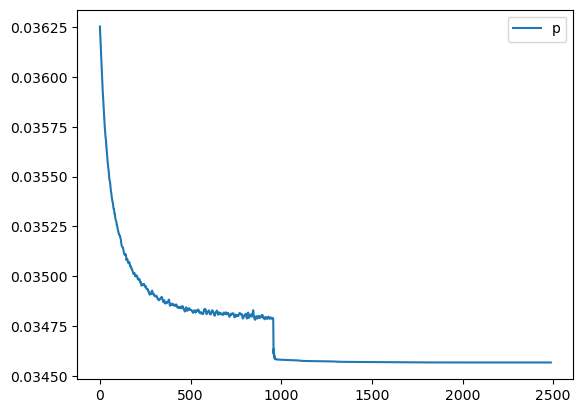

In [9]:

plt.figure(1);plt.clf()
plt.plot(logloss[100:])
plt.legend('prms_only')
plt.show()

(304, 304) (304, 304) (304, 304) (304, 304) (304, 304)
(200, 200) (200, 200) (200, 200) (200, 200) (200, 200)
52
(200, 200) (200, 200) (200, 200) (200, 200) (200, 200)


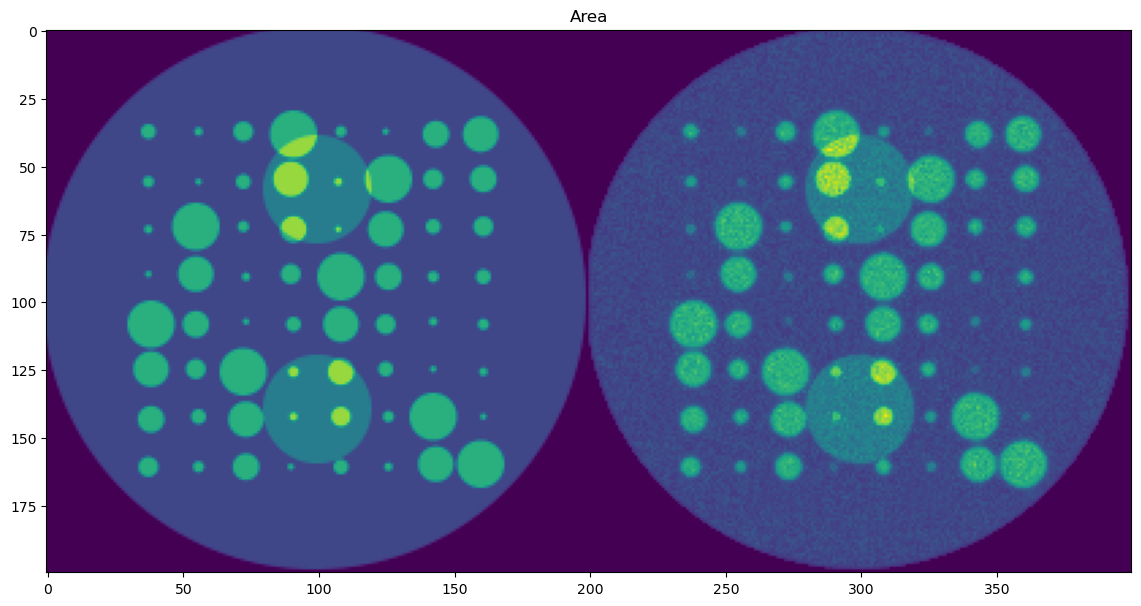

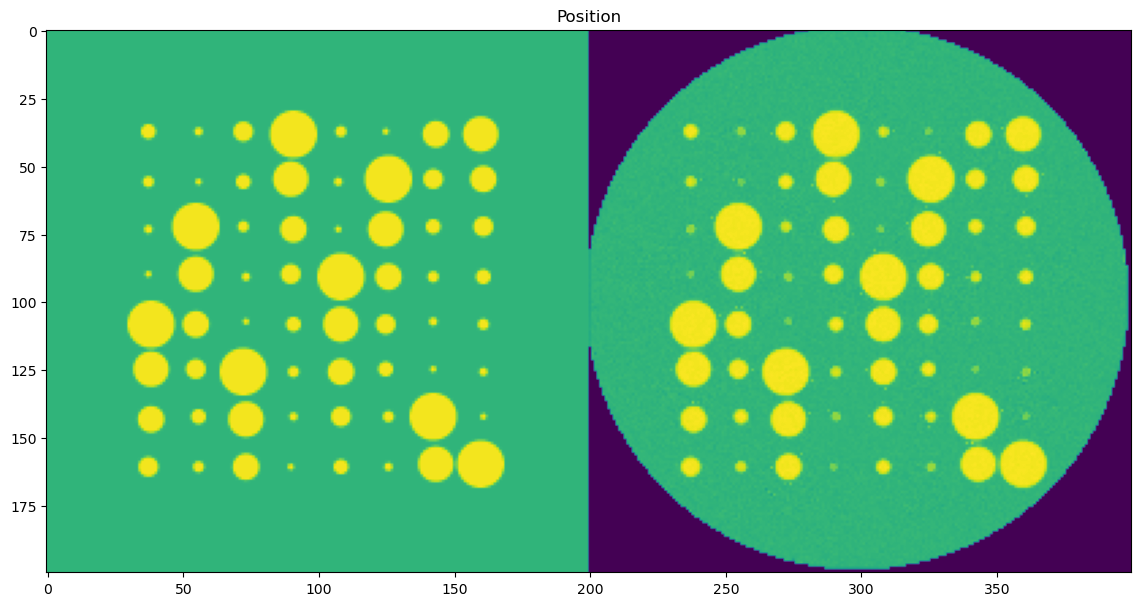

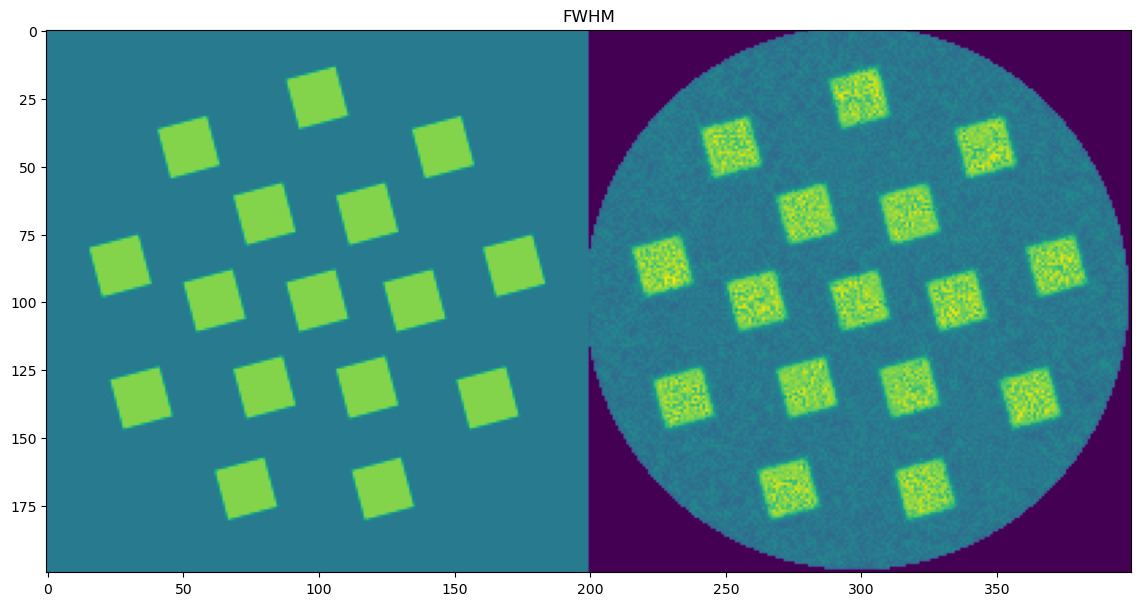

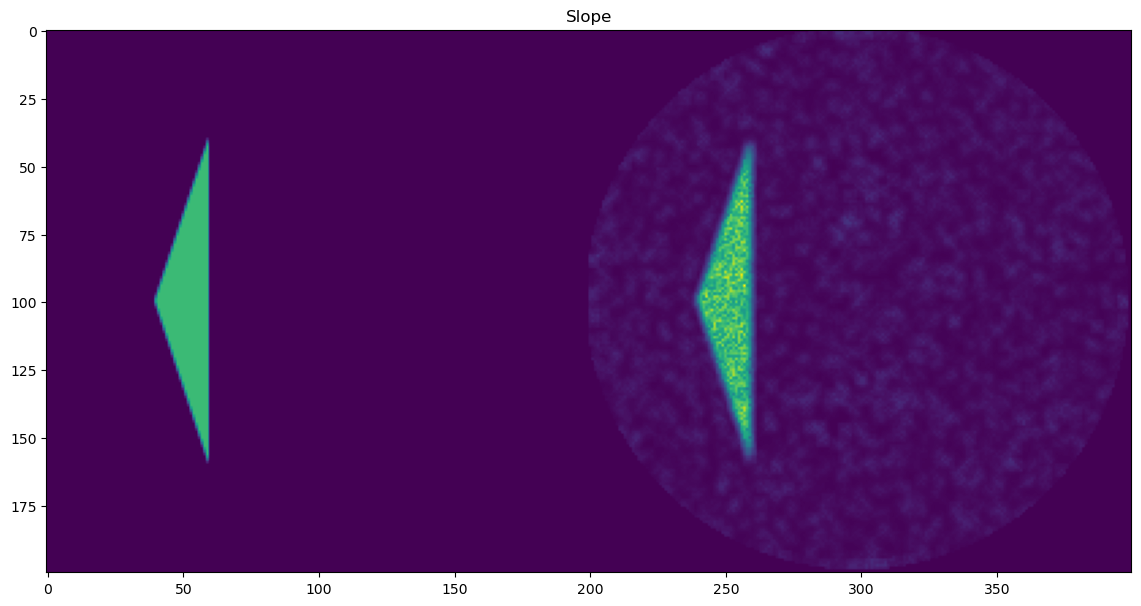

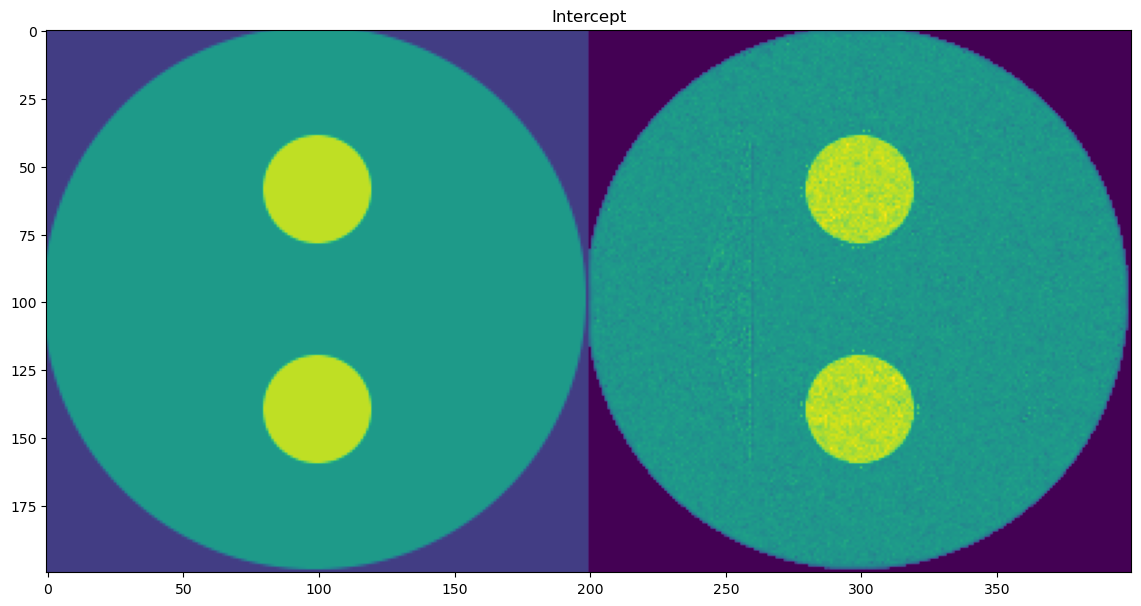

In [10]:
%matplotlib inline

ims = model(im_static)
filtered = nn.AvgPool2d(kernel_size=5, stride=1, padding=2)(ims)
lower_bound = filtered * (1 - prf)
upper_bound = filtered * (1 + prf)
ims = torch.clamp(ims, min=lower_bound, max=upper_bound)

i = 0

prms_peak1_area = denormalize(ims[:, i * 3, :, :], 'Area', param_min, param_max, i)[0,:,:].cpu().detach().numpy()
prms_peak1_pos = denormalize(ims[:, i * 3 + 1, :, :], 'Position', param_min, param_max, i)[0,:,:].cpu().detach().numpy()
prms_peak1_fwhm = denormalize(ims[:, i * 3 + 2, :, :], 'FWHM', param_min, param_max, i)[0,:,:].cpu().detach().numpy()
prms_slope = denormalize(ims[:, -2, :, :], 'Slope', param_min, param_max, )[0,:,:].cpu().detach().numpy()
prms_intercept = denormalize(ims[:, -1, :, :], 'Intercept', param_min, param_max, )[0,:,:].cpu().detach().numpy()

print(prms_peak1_area.shape, prms_peak1_pos.shape, prms_peak1_fwhm.shape, prms_slope.shape, prms_intercept.shape)

print(peak_area.shape, peak_position.shape, peak_fwhm.shape, peak_slope.shape, peak_intercept.shape)


ofs = int((prms_peak1_area.shape[0] - peak_area.shape[0])/2)
print(ofs)

prms_peak1_area = prms_peak1_area[ofs:prms_peak1_area.shape[0]-ofs, ofs:prms_peak1_area.shape[1]-ofs]
prms_peak1_pos = prms_peak1_pos[ofs:prms_peak1_pos.shape[0]-ofs, ofs:prms_peak1_pos.shape[1]-ofs]
prms_peak1_fwhm = prms_peak1_fwhm[ofs:prms_peak1_fwhm.shape[0]-ofs, ofs:prms_peak1_fwhm.shape[1]-ofs]
prms_slope = prms_slope[ofs:prms_slope.shape[0]-ofs, ofs:prms_slope.shape[1]-ofs]
prms_intercept = prms_intercept[ofs:prms_intercept.shape[0]-ofs, ofs:prms_intercept.shape[1]-ofs]

print(prms_peak1_area.shape, prms_peak1_pos.shape, prms_peak1_fwhm.shape, prms_slope.shape, prms_intercept.shape)

msk = np.copy(peak_area)
msk[msk<0.1] = 0
msk[msk>0] = 1

areac = np.concatenate((peak_area, prms_peak1_area*msk), axis = 1)
posc = np.concatenate((peak_position, prms_peak1_pos*msk), axis = 1)
fwhmc = np.concatenate((peak_fwhm, prms_peak1_fwhm*msk), axis = 1)
slopec = np.concatenate((peak_slope, prms_slope*msk), axis = 1)
interceptc = np.concatenate((peak_intercept, prms_intercept*msk), axis = 1)

plt.figure(1, figsize=(14,14));plt.clf()
plt.imshow(areac)
# plt.colorbar()
plt.title('Area')
plt.show()

plt.figure(2, figsize=(14,14));plt.clf()
plt.imshow(posc)
# plt.colorbar()
plt.title('Position')
plt.show()

plt.figure(3, figsize=(14,14));plt.clf()
plt.imshow(fwhmc)
# plt.colorbar()
plt.title('FWHM')
plt.show()

plt.figure(4, figsize=(14,14));plt.clf()
plt.imshow(slopec)
# plt.colorbar()
plt.title('Slope')
plt.show()

plt.figure(5, figsize=(14,14));plt.clf()
plt.imshow(interceptc)
# plt.colorbar()
plt.title('Intercept')
plt.show()



In [21]:

model_cnn = CNN2D_superres(nch_in=volp.shape[2], nch_out=nch_out, nfilts=64,  upscale_factor = 4, norm_type='instance', 
              activation='Sigmoid', padding='same').to(device)
# model_cnn = CNN2D_superres(nch_in=nch_out, nch_out=nch_out, nfilts=64,  upscale_factor = 4, norm_type='instance', 
#               activation='Sigmoid', padding='same').to(device)

nch_in = volp.shape[2]
nfilts = volp.shape[2] # 2*total_params

# Calculate the total number of parameters
model_prms = sum(p.numel() for p in model_cnn.parameters() if p.requires_grad)
print(f"Total number of parameters: {model_prms}")

print('Number of filters:', nfilts)
print(nch_out)

print("Conventional number of parameters:", npix*npix*total_params)


yobs = np.transpose(volp, (2,1,0))
yobs = torch.tensor(yobs, dtype=torch.float32, device=device)
yobs = torch.reshape(yobs, (1, yobs.shape[0], yobs.shape[1], yobs.shape[2]))
yobs = torch.transpose(yobs, 3, 2)
downsampled = F.interpolate(yobs, scale_factor=1/4, mode='bilinear', align_corners=False)

# with torch.no_grad():
#     ims = model(im_static)
# downsampled = F.interpolate(ims, scale_factor=1/4, mode='bilinear', align_corners=False)

print(downsampled.shape, yobs.shape, yobs.shape[2]/4)


Total number of parameters: 105861
Number of filters: 50
5
Conventional number of parameters: 462080
torch.Size([1, 50, 76, 76]) torch.Size([1, 50, 304, 304]) 76.0


In [22]:

nch = volp.shape[2]
learning_rate = 0.001
epochs = 10000
min_lr = 1E-5

yobs = np.transpose(volp, (2,1,0))
yobs = torch.tensor(yobs, dtype=torch.float32, device=device)
yobs = torch.reshape(yobs, (1, yobs.shape[0], yobs.shape[1], yobs.shape[2]))
yobs = torch.transpose(yobs, 3, 2)

##### This is using predefined indices #####

prf = 0.2
epochs = 50000
patience = 250 #250
learning_rate = 0.001
min_lr = 1E-5
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, factor=0.5, min_lr=min_lr, verbose=1)

num_patches = 16
new_indices = np.array(indices)
total_indices = len(indices)
num_batches = (total_indices + num_patches - 1) // num_patches
print(num_batches)

start = time.time()
logloss = []

for epoch in tqdm(range(epochs)):

    loss_acc = 0
    
    for batch_index in range(num_batches):
        start_index = batch_index * num_patches
        end_index = min(start_index + num_patches, total_indices)
        batch_indices = new_indices[start_index:end_index]

        yc = model_cnn(downsampled)

        filtered = nn.AvgPool2d(kernel_size=3, stride=1, padding=1)(yc)
        lower_bound = filtered * (1.0 - prf)
        upper_bound = filtered * (1.0 + prf)
        yc = torch.clamp(yc, min=lower_bound, max=upper_bound)

        yc = calc_patches_indices(batch_indices, yc, patch_size, use_middle=False)

        y = torch.zeros((patch_size*patch_size*len(batch_indices), len(xv)), dtype=torch.float32).to(device)
        
        for i in range(num_peaks):
            area = denormalize(yc[:, i * 3, :, :], 'Area', param_min, param_max, i)
            position = denormalize(yc[:, i * 3 + 1, :, :], 'Position', param_min, param_max, i)
            fwhm = denormalize(yc[:, i * 3 + 2, :, :], 'FWHM', param_min, param_max, i)

            area = torch.transpose(torch.reshape(area, (area.shape[0], area.shape[1]*area.shape[2])), 1, 0)
            position = torch.transpose(torch.reshape(position, (position.shape[0], position.shape[1]*position.shape[2])), 1, 0)
            fwhm = torch.transpose(torch.reshape(fwhm, (fwhm.shape[0], fwhm.shape[1]*fwhm.shape[2])), 1, 0)

            area = torch.reshape(area, (area.shape[0]*area.shape[1], 1))
            position = torch.reshape(position, (area.shape[0]*area.shape[1], 1))
            fwhm = torch.reshape(fwhm, (area.shape[0]*area.shape[1], 1))
            
            y += gaussian(xv.unsqueeze(0), area, position, fwhm)
        
        slope = denormalize(yc[:, -2, :, :], 'Slope', param_min, param_max, )
        intercept = denormalize(yc[:, -1, :, :], 'Intercept', param_min, param_max, )

        slope = torch.transpose(torch.reshape(slope, (slope.shape[0], slope.shape[1]*slope.shape[2])), 1, 0)
        intercept = torch.transpose(torch.reshape(intercept, (intercept.shape[0], intercept.shape[1]*intercept.shape[2])), 1, 0)

        slope = torch.reshape(slope, (slope.shape[0]*slope.shape[1], 1))
        intercept = torch.reshape(intercept, (intercept.shape[0]*intercept.shape[1], 1))

        y += slope * xv + intercept  

        patches = calc_patches_indices(batch_indices, yobs, patch_size, use_middle=False) 
        
        patches = torch.reshape(patches, (patches.shape[0],patches.shape[1],patches.shape[2]*patches.shape[3]))
        patches = torch.transpose(patches, 1, 2)
        patches = torch.transpose(patches, 1, 0)
        y = torch.reshape(y, (patches.shape[0], patches.shape[1], nch))

        loss_mae =  MAE(patches, y)
        loss_mse = torch.mean((patches - y) ** 2)
        loss_rmse = torch.sqrt(torch.mean((patches - y) ** 2))
        
        loss_acc = loss_acc + loss_rmse

        loss = loss_rmse 
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
    loss_acc = loss_acc/num_batches
                
    logloss.append(loss_acc.cpu().detach().numpy())

    scheduler.step(logloss[-1])

    if epoch %  (int(patience/2)) == 0:
        print('MAE = ', loss_mae, 'MSE = ', loss_mse,'RMSE = ', loss_rmse)
        print('Accumulated Loss = ', logloss[-1])
        
    if optimizer.param_groups[0]['lr'] == scheduler.min_lrs[0]:
        print("Minimum learning rate reached, stopping the optimization")
        print(epoch)
        break

total_time = time.time() - start

print(epoch, loss_mae, loss_mse, loss_rmse, logloss[-1])
print(total_time)

3


  0%|          | 3/50000 [00:00<1:24:42,  9.84it/s]

MAE =  tensor(0.2518, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.1315, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.3626, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.46296263


  0%|          | 128/50000 [00:06<40:32, 20.51it/s]

MAE =  tensor(0.0332, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0037, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0604, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.052745655


  1%|          | 254/50000 [00:12<40:37, 20.41it/s]

MAE =  tensor(0.0317, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0032, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0565, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.049816802


  1%|          | 379/50000 [00:18<40:06, 20.62it/s]

MAE =  tensor(0.0302, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0027, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0520, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.04603108


  1%|          | 505/50000 [00:24<39:05, 21.11it/s]

MAE =  tensor(0.0293, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0025, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0501, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.044867627


  1%|▏         | 628/50000 [00:30<38:54, 21.15it/s]

MAE =  tensor(0.0284, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0023, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0475, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.042467233


  2%|▏         | 754/50000 [00:36<39:32, 20.76it/s]

MAE =  tensor(0.0278, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0021, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0461, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.041364685


  2%|▏         | 880/50000 [00:42<39:52, 20.53it/s]

MAE =  tensor(0.0272, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0020, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0442, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.04063895


  2%|▏         | 1003/50000 [00:48<39:56, 20.44it/s]

MAE =  tensor(0.0272, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0019, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0441, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03996674


  2%|▏         | 1128/50000 [00:54<38:19, 21.25it/s]

MAE =  tensor(0.0267, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0018, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0428, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.039241396


  3%|▎         | 1254/50000 [01:00<39:56, 20.34it/s]

MAE =  tensor(0.0269, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0019, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0431, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03914464


  3%|▎         | 1380/50000 [01:06<39:00, 20.77it/s]

MAE =  tensor(0.0264, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0018, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0419, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038555738


  3%|▎         | 1504/50000 [01:12<39:11, 20.63it/s]

MAE =  tensor(0.0265, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0018, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0422, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03859144


  3%|▎         | 1628/50000 [01:18<39:33, 20.38it/s]

MAE =  tensor(0.0267, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0018, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0429, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038899884


  4%|▎         | 1754/50000 [01:24<38:07, 21.10it/s]

MAE =  tensor(0.0267, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0019, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0431, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03912507


  4%|▍         | 1880/50000 [01:30<38:45, 20.69it/s]

MAE =  tensor(0.0261, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0412, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038144503


  4%|▍         | 1949/50000 [01:34<38:29, 20.80it/s]

Epoch 01946: reducing learning rate of group 0 to 5.0000e-04.


  4%|▍         | 2003/50000 [01:36<39:36, 20.20it/s]

MAE =  tensor(0.0259, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0406, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.037616316


  4%|▍         | 2129/50000 [01:42<37:53, 21.05it/s]

MAE =  tensor(0.0260, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0409, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.037727855


  4%|▍         | 2246/50000 [01:48<37:55, 20.98it/s]

Epoch 02242: reducing learning rate of group 0 to 2.5000e-04.


  5%|▍         | 2255/50000 [01:48<37:21, 21.30it/s]

MAE =  tensor(0.0258, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0404, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03746619


  5%|▍         | 2378/50000 [01:54<37:01, 21.44it/s]

MAE =  tensor(0.0258, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0404, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03740117


  5%|▌         | 2504/50000 [02:00<38:18, 20.66it/s]

MAE =  tensor(0.0257, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0403, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03735654


  5%|▌         | 2628/50000 [02:06<38:06, 20.72it/s]

MAE =  tensor(0.0257, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0403, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.037328802


  6%|▌         | 2754/50000 [02:12<40:08, 19.62it/s]

MAE =  tensor(0.0257, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0403, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.037330702


  6%|▌         | 2879/50000 [02:18<36:36, 21.45it/s]

MAE =  tensor(0.0257, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0403, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03731659


  6%|▌         | 3005/50000 [02:24<36:33, 21.43it/s]

MAE =  tensor(0.0258, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0403, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.037312787


  6%|▋         | 3127/50000 [02:30<38:46, 20.15it/s]

MAE =  tensor(0.0256, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0401, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.037196666


  7%|▋         | 3253/50000 [02:36<37:15, 20.91it/s]

MAE =  tensor(0.0257, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0401, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.037207685


  7%|▋         | 3379/50000 [02:42<36:59, 21.01it/s]

MAE =  tensor(0.0257, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0401, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.037200067


  7%|▋         | 3505/50000 [02:48<36:40, 21.13it/s]

MAE =  tensor(0.0256, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0399, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.037105776


  7%|▋         | 3628/50000 [02:54<37:05, 20.84it/s]

MAE =  tensor(0.0256, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0399, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03706524


  8%|▊         | 3753/50000 [03:00<38:41, 19.92it/s]

MAE =  tensor(0.0256, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0398, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.037054665


  8%|▊         | 3879/50000 [03:07<39:52, 19.28it/s]

MAE =  tensor(0.0257, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0400, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03718601


  8%|▊         | 4004/50000 [03:13<36:02, 21.27it/s]

MAE =  tensor(0.0255, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0396, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036955915


  8%|▊         | 4130/50000 [03:19<35:59, 21.25it/s]

MAE =  tensor(0.0255, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0396, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036960628


  9%|▊         | 4253/50000 [03:24<37:58, 20.08it/s]

MAE =  tensor(0.0255, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0396, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036915194


  9%|▉         | 4379/50000 [03:31<35:27, 21.45it/s]

MAE =  tensor(0.0255, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0396, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03690581


  9%|▉         | 4505/50000 [03:37<35:32, 21.34it/s]

MAE =  tensor(0.0255, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0397, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.037037738


  9%|▉         | 4628/50000 [03:42<36:38, 20.64it/s]

MAE =  tensor(0.0255, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0396, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036900587


 10%|▉         | 4754/50000 [03:48<35:04, 21.50it/s]

MAE =  tensor(0.0254, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0394, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036839113


 10%|▉         | 4879/50000 [03:55<37:55, 19.83it/s]

MAE =  tensor(0.0254, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0394, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036811747


 10%|█         | 5003/50000 [04:01<38:32, 19.46it/s]

MAE =  tensor(0.0254, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0394, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036805145


 10%|█         | 5130/50000 [04:07<34:30, 21.67it/s]

MAE =  tensor(0.0253, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0393, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03674028


 11%|█         | 5253/50000 [04:13<34:56, 21.35it/s]

MAE =  tensor(0.0254, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0394, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036752786


 11%|█         | 5379/50000 [04:19<34:55, 21.30it/s]

MAE =  tensor(0.0253, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0394, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036847886


 11%|█         | 5505/50000 [04:25<35:57, 20.63it/s]

MAE =  tensor(0.0254, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0394, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036870625


 11%|█▏        | 5628/50000 [04:31<34:42, 21.31it/s]

MAE =  tensor(0.0254, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0394, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03675638


 12%|█▏        | 5754/50000 [04:36<34:55, 21.11it/s]

MAE =  tensor(0.0254, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0394, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03676477


 12%|█▏        | 5793/50000 [04:38<34:39, 21.25it/s]

Epoch 05790: reducing learning rate of group 0 to 1.2500e-04.


 12%|█▏        | 5880/50000 [04:42<34:37, 21.24it/s]

MAE =  tensor(0.0253, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0391, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036619477


 12%|█▏        | 6003/50000 [04:48<36:45, 19.95it/s]

MAE =  tensor(0.0253, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0392, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03664495


 12%|█▏        | 6129/50000 [04:55<36:55, 19.80it/s]

MAE =  tensor(0.0253, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0392, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036616683


 13%|█▎        | 6254/50000 [05:01<34:01, 21.43it/s]

MAE =  tensor(0.0253, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0392, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03664799


 13%|█▎        | 6380/50000 [05:06<34:30, 21.07it/s]

MAE =  tensor(0.0253, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0392, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036645852


 13%|█▎        | 6503/50000 [05:12<34:18, 21.13it/s]

MAE =  tensor(0.0252, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0391, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036594525


 13%|█▎        | 6629/50000 [05:18<34:27, 20.98it/s]

MAE =  tensor(0.0253, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0391, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036593027


 14%|█▎        | 6755/50000 [05:25<35:35, 20.25it/s]

MAE =  tensor(0.0252, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0391, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036570586


 14%|█▍        | 6878/50000 [05:30<32:53, 21.86it/s]

MAE =  tensor(0.0252, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0391, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03657521


 14%|█▍        | 7004/50000 [05:36<34:45, 20.62it/s]

MAE =  tensor(0.0252, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0391, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03655566


 14%|█▍        | 7129/50000 [05:42<35:32, 20.11it/s]

MAE =  tensor(0.0252, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0391, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036556616


 15%|█▍        | 7253/50000 [05:48<35:26, 20.10it/s]

MAE =  tensor(0.0252, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0390, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03653921


 15%|█▍        | 7378/50000 [05:55<33:14, 21.37it/s]

MAE =  tensor(0.0252, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0391, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036551457


 15%|█▌        | 7504/50000 [06:01<33:19, 21.25it/s]

MAE =  tensor(0.0252, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0390, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036532022


 15%|█▌        | 7630/50000 [06:06<33:12, 21.27it/s]

MAE =  tensor(0.0252, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0391, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036561225


 16%|█▌        | 7753/50000 [06:12<33:58, 20.72it/s]

MAE =  tensor(0.0252, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0391, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03654159


 16%|█▌        | 7879/50000 [06:18<34:13, 20.51it/s]

MAE =  tensor(0.0252, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0391, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03655732


 16%|█▌        | 8004/50000 [06:24<33:01, 21.20it/s]

MAE =  tensor(0.0252, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0390, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036513474


 16%|█▌        | 8094/50000 [06:29<32:48, 21.29it/s]

Epoch 08091: reducing learning rate of group 0 to 6.2500e-05.


 16%|█▋        | 8130/50000 [06:30<32:46, 21.30it/s]

MAE =  tensor(0.0252, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0390, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036474388


 17%|█▋        | 8253/50000 [06:36<35:23, 19.66it/s]

MAE =  tensor(0.0252, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0390, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036470484


 17%|█▋        | 8379/50000 [06:43<34:50, 19.91it/s]

MAE =  tensor(0.0252, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0390, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036470145


 17%|█▋        | 8505/50000 [06:49<33:11, 20.84it/s]

MAE =  tensor(0.0252, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0390, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036466926


 17%|█▋        | 8628/50000 [06:55<31:36, 21.82it/s]

MAE =  tensor(0.0252, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0390, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036473267


 18%|█▊        | 8754/50000 [07:00<33:06, 20.77it/s]

MAE =  tensor(0.0252, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0389, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036455594


 18%|█▊        | 8880/50000 [07:06<32:54, 20.82it/s]

MAE =  tensor(0.0252, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0390, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036462553


 18%|█▊        | 9003/50000 [07:12<32:01, 21.34it/s]

MAE =  tensor(0.0252, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0389, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036453735


 18%|█▊        | 9129/50000 [07:18<33:13, 20.51it/s]

MAE =  tensor(0.0252, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0390, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036457717


 19%|█▊        | 9255/50000 [07:24<31:38, 21.46it/s]

MAE =  tensor(0.0252, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0390, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03645992


 19%|█▉        | 9378/50000 [07:30<34:31, 19.61it/s]

MAE =  tensor(0.0252, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0389, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036458295


 19%|█▉        | 9503/50000 [07:36<33:24, 20.20it/s]

MAE =  tensor(0.0251, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0389, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03643652


 19%|█▉        | 9628/50000 [07:42<32:35, 20.65it/s]

MAE =  tensor(0.0251, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0389, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03642764


 20%|█▉        | 9754/50000 [07:49<31:45, 21.13it/s]

MAE =  tensor(0.0251, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0389, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036428086


 20%|█▉        | 9880/50000 [07:54<30:59, 21.57it/s]

MAE =  tensor(0.0251, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0389, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036424186


 20%|██        | 10003/50000 [08:00<33:09, 20.11it/s]

MAE =  tensor(0.0251, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0389, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036415976


 20%|██        | 10129/50000 [08:06<32:05, 20.71it/s]

MAE =  tensor(0.0251, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0389, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036418617


 21%|██        | 10255/50000 [08:12<31:14, 21.21it/s]

MAE =  tensor(0.0251, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0389, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036411606


 21%|██        | 10378/50000 [08:18<32:08, 20.54it/s]

MAE =  tensor(0.0251, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0389, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036423415


 21%|██        | 10504/50000 [08:24<31:16, 21.05it/s]

MAE =  tensor(0.0251, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0389, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036409788


 21%|██▏       | 10629/50000 [08:30<33:41, 19.48it/s]

MAE =  tensor(0.0251, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0389, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03641481


 21%|██▏       | 10699/50000 [08:34<33:30, 19.55it/s]

Epoch 10697: reducing learning rate of group 0 to 3.1250e-05.


 22%|██▏       | 10754/50000 [08:37<32:29, 20.13it/s]

MAE =  tensor(0.0251, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0388, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036383294


 22%|██▏       | 10877/50000 [08:42<31:45, 20.54it/s]

MAE =  tensor(0.0251, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0388, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03638132


 22%|██▏       | 11003/50000 [08:48<31:10, 20.85it/s]

MAE =  tensor(0.0251, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0388, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036380365


 22%|██▏       | 11129/50000 [08:54<30:40, 21.12it/s]

MAE =  tensor(0.0251, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0388, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036379617


 23%|██▎       | 11252/50000 [09:00<30:59, 20.84it/s]

MAE =  tensor(0.0251, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0388, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036376204


 23%|██▎       | 11378/50000 [09:06<31:17, 20.57it/s]

MAE =  tensor(0.0251, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0388, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036372267


 23%|██▎       | 11504/50000 [09:12<30:52, 20.78it/s]

MAE =  tensor(0.0251, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0388, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.0363706


 23%|██▎       | 11630/50000 [09:18<30:07, 21.22it/s]

MAE =  tensor(0.0251, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0388, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036371447


 24%|██▎       | 11754/50000 [09:24<32:19, 19.72it/s]

MAE =  tensor(0.0251, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0388, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036364436


 24%|██▍       | 11878/50000 [09:31<31:48, 19.98it/s]

MAE =  tensor(0.0251, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0388, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036361933


 24%|██▍       | 12004/50000 [09:37<29:56, 21.15it/s]

MAE =  tensor(0.0251, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0388, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036363836


 24%|██▍       | 12130/50000 [09:43<30:19, 20.81it/s]

MAE =  tensor(0.0251, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0388, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036360398


 25%|██▍       | 12253/50000 [09:48<31:02, 20.27it/s]

MAE =  tensor(0.0251, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0388, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036354948


 25%|██▍       | 12379/50000 [09:54<29:31, 21.23it/s]

MAE =  tensor(0.0251, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0388, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.0363505


 25%|██▌       | 12505/50000 [10:00<29:57, 20.86it/s]

MAE =  tensor(0.0251, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0388, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036349766


 25%|██▌       | 12628/50000 [10:06<29:16, 21.28it/s]

MAE =  tensor(0.0251, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0388, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03634756


 26%|██▌       | 12754/50000 [10:12<29:45, 20.87it/s]

MAE =  tensor(0.0251, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0388, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036342766


 26%|██▌       | 12880/50000 [10:18<30:06, 20.55it/s]

MAE =  tensor(0.0251, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0388, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03634088


 26%|██▌       | 13004/50000 [10:24<30:19, 20.33it/s]

MAE =  tensor(0.0251, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0388, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03634041


 26%|██▋       | 13129/50000 [10:30<29:00, 21.18it/s]

MAE =  tensor(0.0251, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0388, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03633722


 27%|██▋       | 13255/50000 [10:36<28:40, 21.36it/s]

MAE =  tensor(0.0251, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0388, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03633391


 27%|██▋       | 13378/50000 [10:42<28:54, 21.12it/s]

MAE =  tensor(0.0251, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0388, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03633103


 27%|██▋       | 13504/50000 [10:48<29:28, 20.64it/s]

MAE =  tensor(0.0251, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0388, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03633203


 27%|██▋       | 13525/50000 [10:49<28:24, 21.40it/s]

Epoch 13522: reducing learning rate of group 0 to 1.5625e-05.


 27%|██▋       | 13629/50000 [10:54<29:46, 20.36it/s]

MAE =  tensor(0.0251, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0388, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036324333


 28%|██▊       | 13754/50000 [11:00<28:05, 21.51it/s]

MAE =  tensor(0.0251, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0388, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036323156


 28%|██▊       | 13880/50000 [11:06<28:38, 21.01it/s]

MAE =  tensor(0.0251, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0388, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036321875


 28%|██▊       | 13973/50000 [11:11<28:50, 20.82it/s]

Epoch 13974: reducing learning rate of group 0 to 1.0000e-05.
Minimum learning rate reached, stopping the optimization
13973
13973 tensor(0.0251, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0388, device='cuda:0', grad_fn=<SqrtBackward0>) 0.036320493
671.3029370307922


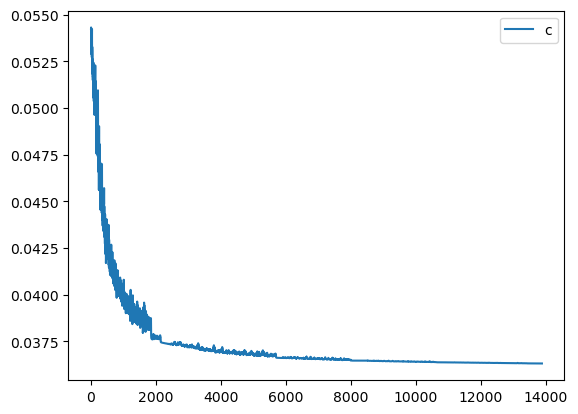

In [23]:
plt.figure(1);plt.clf()
plt.plot(logloss[100:])
plt.legend('cnn')
plt.show()

52


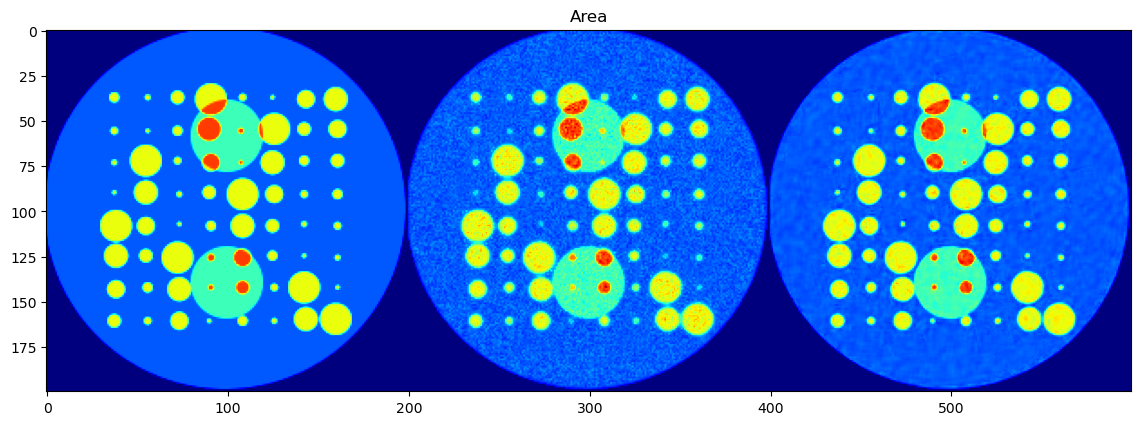

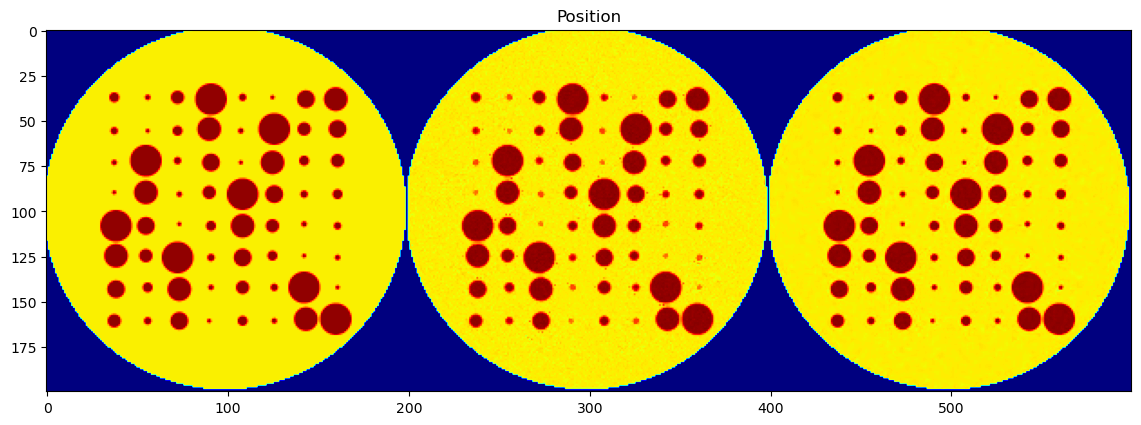

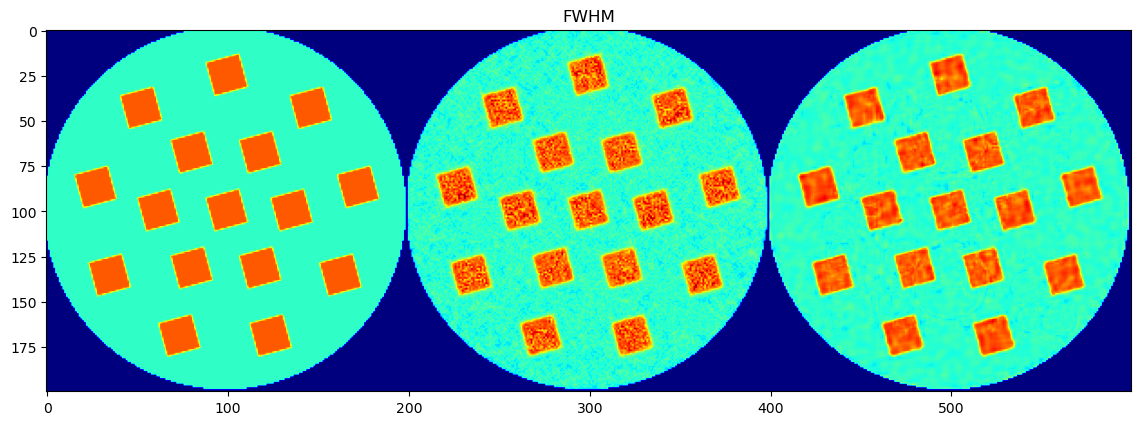

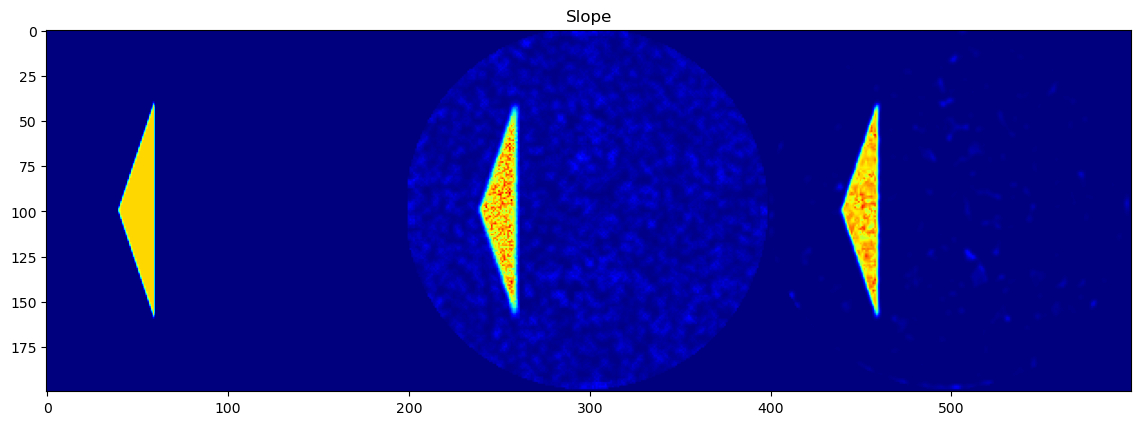

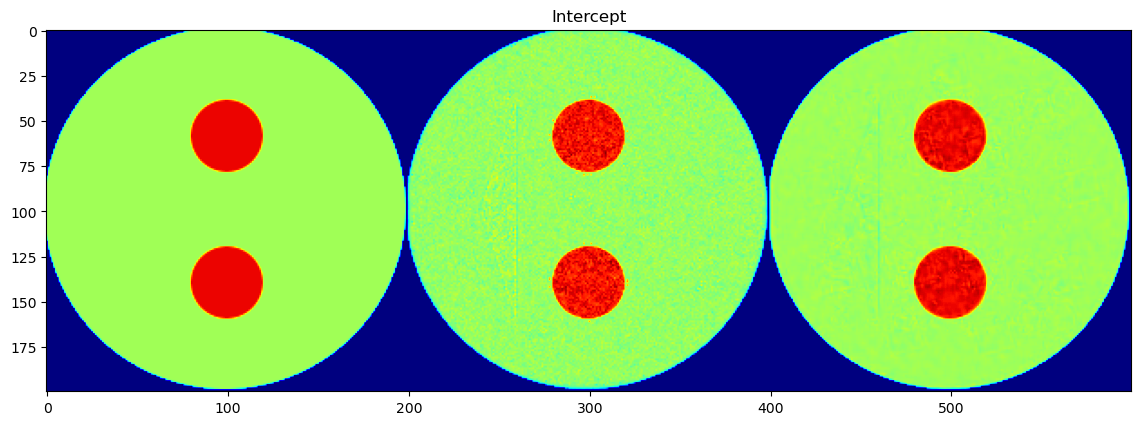

In [24]:
%matplotlib inline

ims = model_cnn(downsampled)

filtered = nn.AvgPool2d(kernel_size=3, stride=1, padding=1)(ims)
lower_bound = filtered * (1 - prf)
upper_bound = filtered * (1 + prf)
ims = torch.clamp(ims, min=lower_bound, max=upper_bound)

i = 0

cnn_peak1_area = denormalize(ims[:, i * 3, :, :], 'Area', param_min, param_max, i)[0,:,:].cpu().detach().numpy()
cnn_peak1_pos = denormalize(ims[:, i * 3 + 1, :, :], 'Position', param_min, param_max, i)[0,:,:].cpu().detach().numpy()
cnn_peak1_fwhm = denormalize(ims[:, i * 3 + 2, :, :], 'FWHM', param_min, param_max, i)[0,:,:].cpu().detach().numpy()
cnn_slope = denormalize(ims[:, -2, :, :], 'Slope', param_min, param_max, )[0,:,:].cpu().detach().numpy()
cnn_intercept = denormalize(ims[:, -1, :, :], 'Intercept', param_min, param_max, )[0,:,:].cpu().detach().numpy()

ofs = int((cnn_peak1_area.shape[0] - peak_area.shape[0])/2)
print(ofs)

cnn_peak1_area = cnn_peak1_area[ofs:cnn_peak1_area.shape[0]-ofs, ofs:cnn_peak1_area.shape[1]-ofs]
cnn_peak1_pos = cnn_peak1_pos[ofs:cnn_peak1_pos.shape[0]-ofs, ofs:cnn_peak1_pos.shape[1]-ofs]
cnn_peak1_fwhm = cnn_peak1_fwhm[ofs:cnn_peak1_fwhm.shape[0]-ofs, ofs:cnn_peak1_fwhm.shape[1]-ofs]
cnn_slope = cnn_slope[ofs:cnn_slope.shape[0]-ofs, ofs:cnn_slope.shape[1]-ofs]
cnn_intercept = cnn_intercept[ofs:cnn_intercept.shape[0]-ofs, ofs:cnn_intercept.shape[1]-ofs]

msk = np.copy(peak_area)
msk[msk<0.1] = 0
msk[msk>0] = 1

areac = np.concatenate((peak_area*msk, prms_peak1_area*msk, cnn_peak1_area*msk), axis = 1)
posc = np.concatenate((peak_position*msk, prms_peak1_pos*msk, cnn_peak1_pos*msk), axis = 1)
fwhmc = np.concatenate((peak_fwhm*msk, prms_peak1_fwhm*msk, cnn_peak1_fwhm*msk), axis = 1)
slopec = np.concatenate((peak_slope*msk, prms_slope*msk, cnn_slope*msk), axis = 1)
interceptc = np.concatenate((peak_intercept*msk, prms_intercept*msk, cnn_intercept*msk), axis = 1)

plt.figure(1, figsize=(14,14));plt.clf()
plt.imshow(areac, cmap = 'jet')
# plt.colorbar()
plt.title('Area')
plt.show()

plt.figure(2, figsize=(14,14));plt.clf()
plt.imshow(posc, cmap = 'jet')
# plt.colorbar()
plt.title('Position')
plt.show()

plt.figure(3, figsize=(14,14));plt.clf()
plt.imshow(fwhmc, cmap = 'jet')
# plt.colorbar()
plt.title('FWHM')
plt.show()

plt.figure(4, figsize=(14,14));plt.clf()
plt.imshow(slopec, cmap = 'jet')
# plt.colorbar()
plt.title('Slope')
plt.show()

plt.figure(5, figsize=(14,14));plt.clf()
plt.imshow(interceptc, cmap = 'jet')
# plt.colorbar()
plt.title('Intercept')
plt.show()


Create sinogram volume

In [40]:
from nDTomo.torch.tomo_torch import forward_project_3D

In [47]:
def linear_background(x, slope, intercept):
    return slope*x + intercept

def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2*sigma**2))

# Define the x axis
# x = np.arange(0, 5, 0.025)
# x = np.arange(0, 5, 0.075)
x = np.arange(0, 5, 0.1)

# Define the min/max for the various parameters

peak1_mu_min = 2
peak1_mu_max = 3

peak1_sigma_min = 0.2
peak1_sigma_max = 0.4

peak1_A_min = 0
peak1_A_max = 1.25

bkg_slope_min = 0.0
bkg_slope_max = 0.025

bkg_intercept_min = 0.05
bkg_intercept_max = 0.25

im6 = im2 + im5
im6 = im6 / np.max(im6)

peak_area = peak1_A_min + im6*(peak1_A_max - peak1_A_min)
peak_position = peak1_mu_min + im2*(peak1_mu_max - peak1_mu_min)
peak_fwhm = peak1_sigma_min + im3*(peak1_sigma_max - peak1_sigma_min)
peak_slope = bkg_slope_min + im4*(bkg_slope_max - bkg_slope_min)
peak_intercept = bkg_intercept_min + im5*(bkg_intercept_max - bkg_intercept_min)

vol = np.zeros((im1.shape[0], im1.shape[1], len(x)), dtype = 'float32')

mask_tmp = np.copy(peak_area)
mask_tmp[mask_tmp<0.0001] = 0
mask_tmp[mask_tmp>0] = 1

for ii in tqdm(range(im1.shape[0])):
    for jj in range(im1.shape[1]):
        if mask_tmp[ii,jj] > 0:
            vol[ii,jj,:] = gaussian(x, A=peak_area[ii,jj], mu=peak_position[ii,jj], sigma=peak_fwhm[ii,jj]) + \
                           linear_background(x, slope=peak_slope[ii,jj], intercept=peak_intercept[ii,jj])

extra = 20
vol = np.concatenate((np.zeros((vol.shape[0], extra, len(x)), dtype = 'float32'), vol, np.zeros((vol.shape[0], extra, len(x)), dtype = 'float32')), axis=1)
vol = np.concatenate((np.zeros((extra, vol.shape[1], len(x)), dtype = 'float32'), vol, np.zeros((extra, vol.shape[1], len(x)), dtype = 'float32')), axis=0)

print(vol.shape, np.max(vol))


num_iterations = 100
distribution_type = 'uniform'
std_dev = int(vol.shape[0] / 1)
device = 'cuda'
patch_size = 32
num_patches = 16
num_patches_total = 16

mask = np.copy(np.sum(vol,axis=2))
mask[mask>0] = 1
mask = np.concatenate((np.zeros((patch_size, mask.shape[1]), dtype='float32'), mask, np.zeros((patch_size, mask.shape[1]), dtype='float32')), axis = 0)
mask = np.concatenate((np.zeros((mask.shape[0], patch_size), dtype='float32'), mask, np.zeros((mask.shape[0], patch_size), dtype='float32')), axis = 1)

volp = np.copy(vol)
volp = np.concatenate((np.zeros((patch_size, volp.shape[1], volp.shape[2]), dtype='float32'), volp, np.zeros((patch_size, volp.shape[1], volp.shape[2]), dtype='float32')), axis = 0)
volp = np.concatenate((np.zeros((volp.shape[0], patch_size, volp.shape[2]), dtype='float32'), volp, np.zeros((volp.shape[0], patch_size, volp.shape[2]), dtype='float32')), axis = 1)
rows, cols = volp.shape[0], volp.shape[1]  # Size of the matrix
print(volp.shape, vol.shape, mask.shape)

yobs = np.transpose(volp, (2,1,0))
yobs = torch.tensor(yobs, dtype=torch.float32, device=device)
yobs = torch.reshape(yobs, (1, yobs.shape[0], yobs.shape[1], yobs.shape[2]))
yobs = torch.transpose(yobs, 3, 2)#[0,:,:,:]
print(yobs.shape)

angles = np.linspace(0, 180, 360, endpoint=False)
s = forward_project_3D(yobs, angles, npix=yobs.shape[2], nch=yobs.shape[1], device='cuda')
print(s.shape)

100%|██████████| 200/200 [00:00<00:00, 539.91it/s]


(240, 240, 50) 1.5
(304, 304, 50) (240, 240, 50) (304, 304)
torch.Size([1, 50, 304, 304])
torch.Size([50, 304, 360])


In [89]:

npix_x = volp.shape[0]
npix_y = volp.shape[1]
xv = torch.tensor(x, dtype=torch.float32, device='cuda')

### Single peak
peak_definitions = [(1, 1.0, 4.0)]

num_peaks = len(peak_definitions)
num_params_per_peak = 3  # Area, Position, FWHM
background_params = 2  # Slope, Intercept
total_params = num_peaks * num_params_per_peak + background_params

npix = volp.shape[0]
nch_in = total_params
nch_out = total_params
nfilts = 2*total_params # 2*total_params is pretty good when using norm layer
norm_type='layer'
activation='Sigmoid'
downsampling = 8
device = 'cuda'

model = CNN2D(npix, nch_in=nch_in, nch_out=nch_out, nfilts=nfilts, nlayers=1, norm_type='None',
               prms_layer=True, cnn_layer=False, tensor_vals = 'zeros').to(device)
model_prms = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of parameters: {model_prms}")
print("Conventional number of parameters:", npix*npix*total_params)

yc = model(im_static)

print(yc.shape)

Total number of parameters: 462080
Conventional number of parameters: 462080
torch.Size([1, 5, 304, 304])


In [ ]:

def gaussian(x, area, position, fwhm):
    """Gaussian peak shape."""
    return area * torch.exp(-(x - position)**2 / (2 * fwhm**2))
    
MAE = torch.nn.L1Loss()


### Single peak ###
param_min = {
    'Area': torch.zeros(num_peaks, dtype=torch.float32).to(device),
    'Position': torch.tensor([peak[1] for peak in peak_definitions], dtype=torch.float32).to(device),
    'FWHM': torch.zeros(num_peaks, dtype=torch.float32).to(device) + 0.1,
    'Fraction': torch.zeros(num_peaks, dtype=torch.float32).to(device),
    'Slope': torch.zeros(1, dtype=torch.float32).to(device),
    'Intercept': torch.zeros(1, dtype=torch.float32).to(device),
}
param_max = {
    'Area': torch.zeros(num_peaks, dtype=torch.float32).to(device) + 2,
    'Position': torch.tensor([peak[2] for peak in peak_definitions], dtype=torch.float32).to(device),
    'FWHM': torch.zeros(num_peaks, dtype=torch.float32).to(device) + 0.5,
    'Fraction': torch.zeros(num_peaks, dtype=torch.float32).to(device) + 1,
    'Slope': torch.zeros(1, dtype=torch.float32).to(device) + 0.2,
    'Intercept': torch.zeros(1, dtype=torch.float32).to(device) + 0.5,
}    

# bkg_slope_min = -0.01
# bkg_slope_max = 0.01
# bkg_intercept_min = 0.05
# bkg_intercept_max = 0.25

nch = volp.shape[2]

# rand_static = torch.randn(1, nch_in, npix, npix).to(device)
im_static = np.sum(volp, axis=2)
im_static = im_static/np.max(im_static)
im_static = np.reshape(im_static, (1, 1, volp.shape[1], volp.shape[1]))
im_static = torch.tensor(im_static, dtype=torch.float32, device=device)

##### This is using predefined indices #####

epochs = 50000
patience = 10 #250
min_lr = 1E-5
learning_rate = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
prf = 0.2
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, factor=0.5, min_lr=min_lr, verbose=1)

start = time.time()
logloss = []

for epoch in tqdm(range(epochs)):

    loss_acc = 0
    
    yc = model(im_static)

    # filtered = nn.AvgPool2d(kernel_size=3, stride=1, padding=1)(yc)
    # lower_bound = filtered * (1 - prf)
    # upper_bound = filtered * (1 + prf)
    # yc = torch.clamp(yc, min=lower_bound, max=upper_bound)

    y = torch.zeros((npix*npix, len(xv)), dtype=torch.float32).to(device)
    for i in range(num_peaks):
        
        area = denormalize(yc[:, i * 3, :, :], 'Area', param_min, param_max, i)
        position = denormalize(yc[:, i * 3 + 1, :, :], 'Position', param_min, param_max, i)
        fwhm = denormalize(yc[:, i * 3 + 2, :, :], 'FWHM', param_min, param_max, i)

        area = torch.transpose(torch.reshape(area, (area.shape[0], area.shape[1]*area.shape[2])), 1, 0)
        position = torch.transpose(torch.reshape(position, (position.shape[0], position.shape[1]*position.shape[2])), 1, 0)
        fwhm = torch.transpose(torch.reshape(fwhm, (fwhm.shape[0], fwhm.shape[1]*fwhm.shape[2])), 1, 0)

        area = torch.reshape(area, (area.shape[0]*area.shape[1], 1))
        position = torch.reshape(position, (area.shape[0]*area.shape[1], 1))
        fwhm = torch.reshape(fwhm, (area.shape[0]*area.shape[1], 1))
        
        y += gaussian(xv.unsqueeze(0), area, position, fwhm)

    slope = denormalize(yc[:, -2, :, :], 'Slope', param_min, param_max, )
    intercept = denormalize(yc[:, -1, :, :], 'Intercept', param_min, param_max, )

    slope = torch.transpose(torch.reshape(slope, (slope.shape[0], slope.shape[1]*slope.shape[2])), 1, 0)
    intercept = torch.transpose(torch.reshape(intercept, (intercept.shape[0], intercept.shape[1]*intercept.shape[2])), 1, 0)

    slope = torch.reshape(slope, (slope.shape[0]*slope.shape[1], 1))
    intercept = torch.reshape(intercept, (intercept.shape[0]*intercept.shape[1], 1))

    y += slope * xv + intercept  
    y = torch.reshape(y, (1, npix, npix, nch))
    y = torch.transpose(y, 3, 1)
    y = torch.transpose(y, 3, 2)

    s_gen = forward_project_3D(y, angles, npix=yobs.shape[2], nch=yobs.shape[1], device='cuda')


    loss_mae =  MAE(s, s_gen)
    loss_mse = torch.mean((s - s_gen) ** 2)
    loss_rmse = torch.sqrt(torch.mean((s - s_gen) ** 2))
    
    loss = loss_rmse 
    optimizer.zero_grad()
    loss.backward()

    optimizer.step()
                
    logloss.append(loss.cpu().detach().numpy())

    scheduler.step(logloss[-1])

    if epoch %  (int(patience/2)) == 0:
        print('MAE = ', loss_mae, 'MSE = ', loss_mse,'RMSE = ', loss_rmse)
        print('Accumulated Loss = ', logloss[-1])
        
    if optimizer.param_groups[0]['lr'] == scheduler.min_lrs[0]:
        print("Minimum learning rate reached, stopping the optimization")
        print(epoch)
        break

total_time = time.time() - start

print(epoch, loss_mae, loss_mse, loss_rmse, logloss[-1])
print(total_time)

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 1/50000 [00:01<17:21:54,  1.25s/it]

MAE =  tensor(151.3140, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(30807.1035, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(175.5195, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  175.51953


  0%|          | 6/50000 [00:06<14:43:49,  1.06s/it]

MAE =  tensor(104.0182, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(14064.9365, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(118.5957, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  118.59569


  0%|          | 11/50000 [00:11<14:34:47,  1.05s/it]

MAE =  tensor(65.3246, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(5657.8481, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(75.2187, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  75.218666


  0%|          | 16/50000 [00:16<14:30:40,  1.05s/it]

MAE =  tensor(37.7381, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(2089.5823, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(45.7119, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  45.71195


  0%|          | 21/50000 [00:22<14:27:25,  1.04s/it]

MAE =  tensor(21.5735, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(699.4257, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(26.4467, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  26.446657


  0%|          | 26/50000 [00:27<14:28:04,  1.04s/it]

MAE =  tensor(15.6535, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(356.7410, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(18.8876, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  18.887589


  0%|          | 31/50000 [00:32<14:29:58,  1.04s/it]

MAE =  tensor(13.3055, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(263.1046, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(16.2205, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  16.2205


  0%|          | 36/50000 [00:37<14:31:50,  1.05s/it]

MAE =  tensor(12.4671, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(232.1281, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(15.2358, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  15.235752


  0%|          | 41/50000 [00:43<14:30:39,  1.05s/it]

MAE =  tensor(11.4681, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(203.2842, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(14.2578, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  14.257777


  0%|          | 46/50000 [00:48<14:27:37,  1.04s/it]

MAE =  tensor(10.1419, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(153.6318, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(12.3948, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  12.394828


  0%|          | 51/50000 [00:53<14:30:06,  1.05s/it]

MAE =  tensor(8.7668, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(105.4842, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(10.2706, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  10.270553


  0%|          | 56/50000 [00:58<14:30:11,  1.05s/it]

MAE =  tensor(7.6085, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(83.6470, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(9.1459, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  9.145872


  0%|          | 60/50000 [01:02<14:36:32,  1.05s/it]

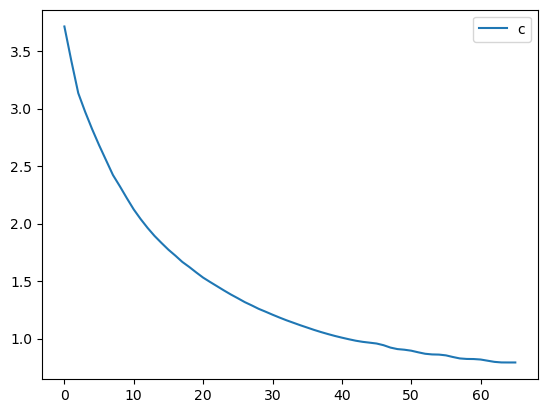

In [87]:
plt.figure(1);plt.clf()
plt.plot(logloss[3:])
plt.legend('cnn')
plt.show()

(304, 304) (304, 304) (304, 304) (304, 304) (304, 304)
(200, 200) (200, 200) (200, 200) (200, 200) (200, 200)
52
(200, 200) (200, 200) (200, 200) (200, 200) (200, 200)


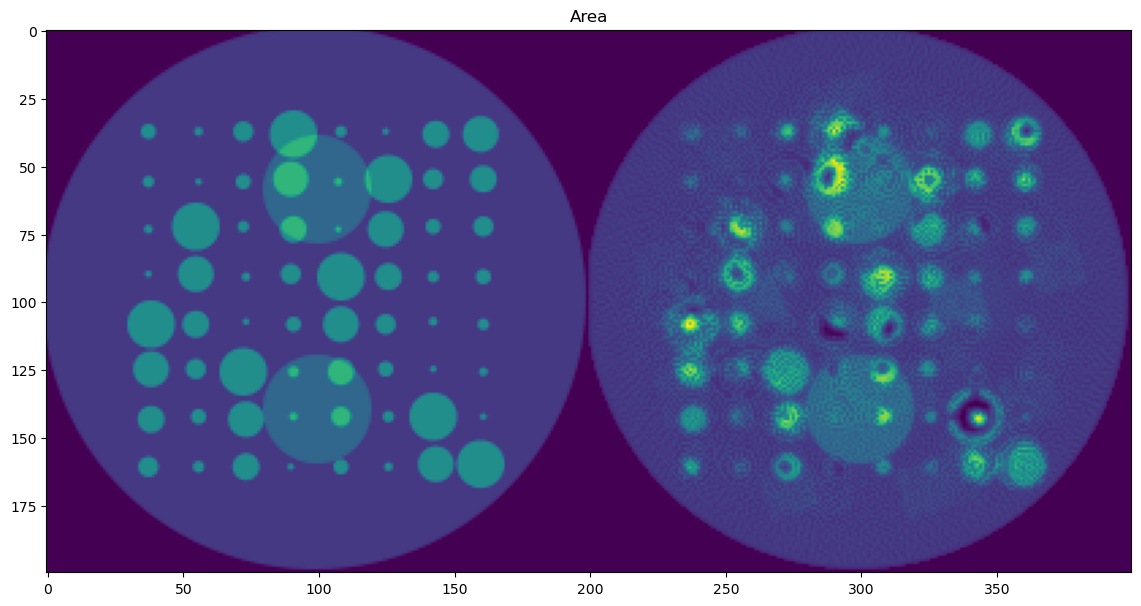

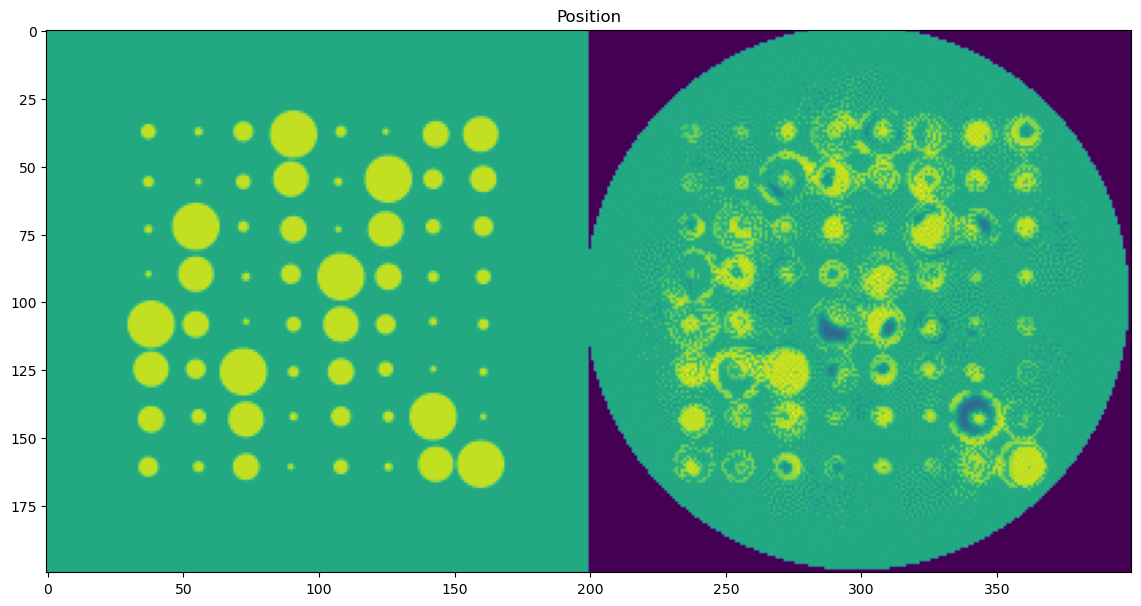

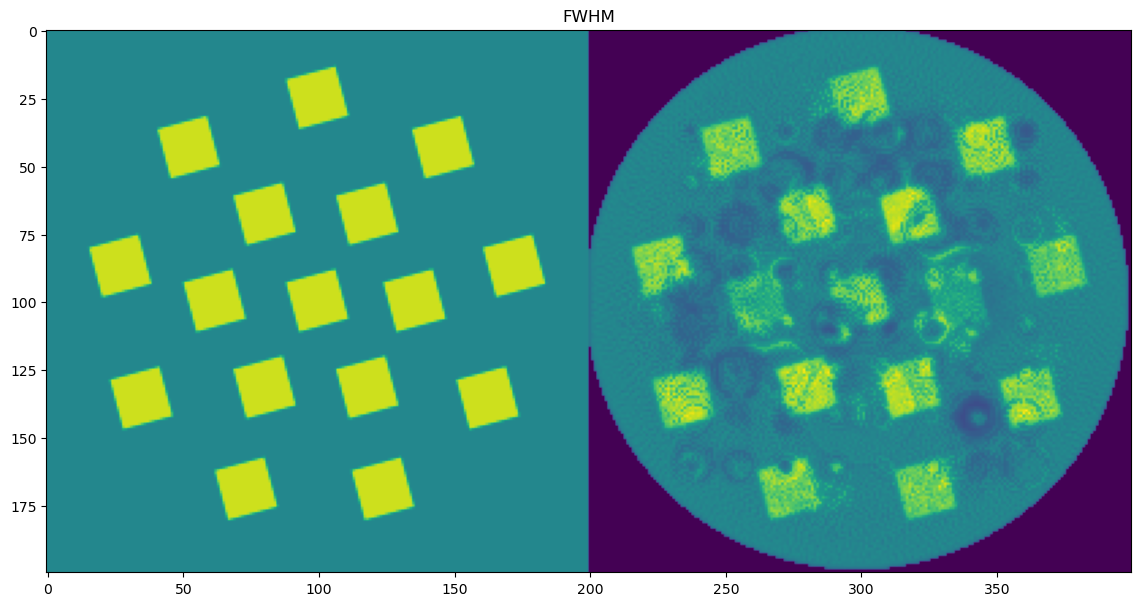

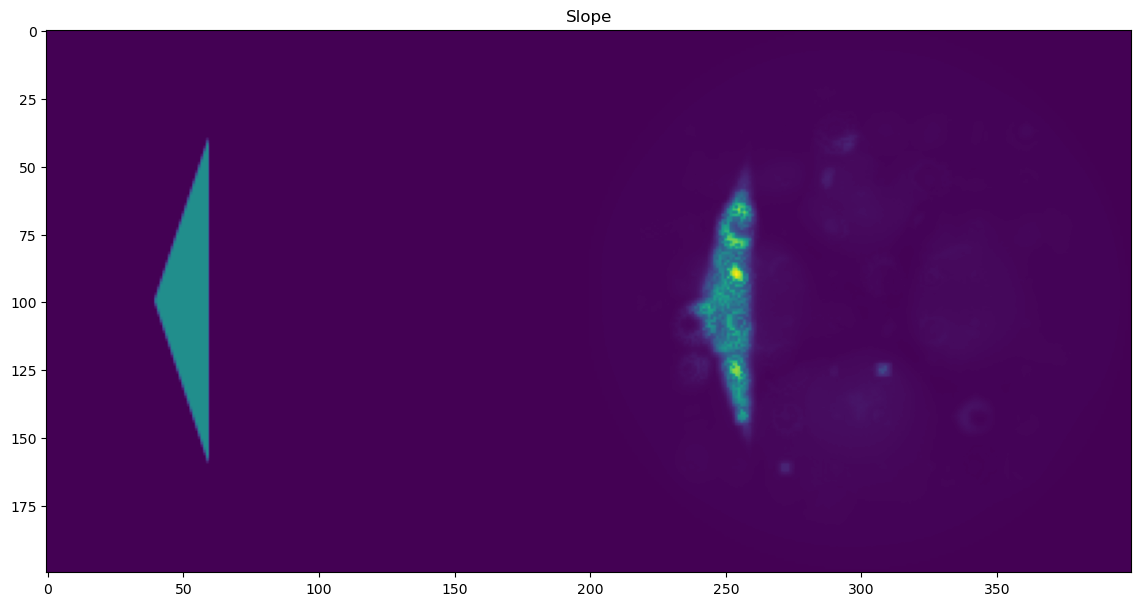

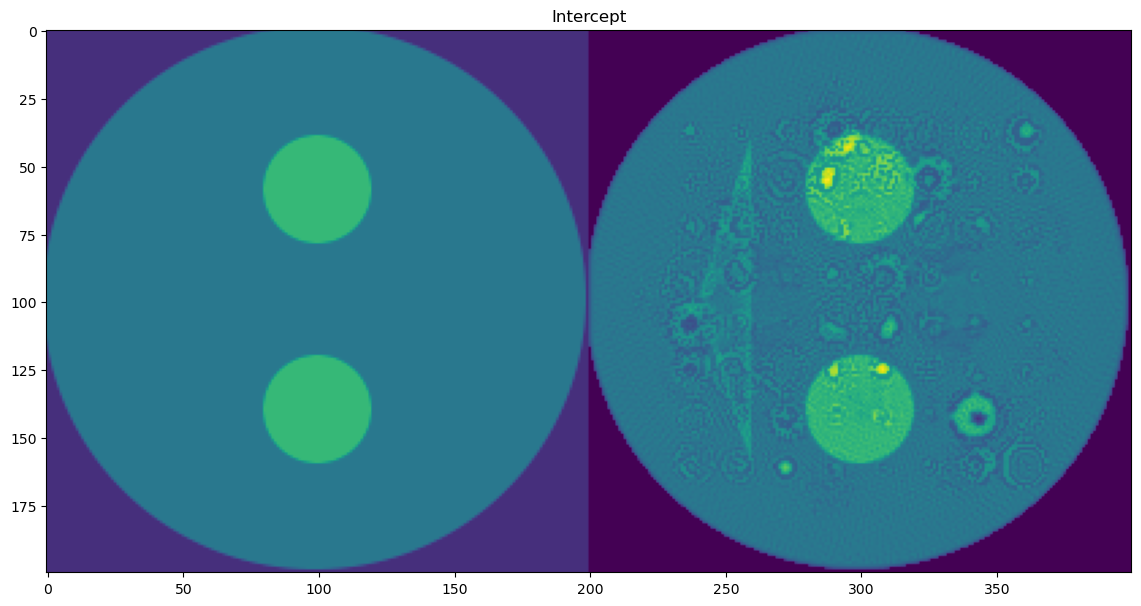

In [88]:
%matplotlib inline

ims = model(im_static)
filtered = nn.AvgPool2d(kernel_size=5, stride=1, padding=2)(ims)
lower_bound = filtered * (1 - prf)
upper_bound = filtered * (1 + prf)
ims = torch.clamp(ims, min=lower_bound, max=upper_bound)

i = 0

prms_peak1_area = denormalize(ims[:, i * 3, :, :], 'Area', param_min, param_max, i)[0,:,:].cpu().detach().numpy()
prms_peak1_pos = denormalize(ims[:, i * 3 + 1, :, :], 'Position', param_min, param_max, i)[0,:,:].cpu().detach().numpy()
prms_peak1_fwhm = denormalize(ims[:, i * 3 + 2, :, :], 'FWHM', param_min, param_max, i)[0,:,:].cpu().detach().numpy()
prms_slope = denormalize(ims[:, -2, :, :], 'Slope', param_min, param_max, )[0,:,:].cpu().detach().numpy()
prms_intercept = denormalize(ims[:, -1, :, :], 'Intercept', param_min, param_max, )[0,:,:].cpu().detach().numpy()

print(prms_peak1_area.shape, prms_peak1_pos.shape, prms_peak1_fwhm.shape, prms_slope.shape, prms_intercept.shape)

print(peak_area.shape, peak_position.shape, peak_fwhm.shape, peak_slope.shape, peak_intercept.shape)


ofs = int((prms_peak1_area.shape[0] - peak_area.shape[0])/2)
print(ofs)

prms_peak1_area = prms_peak1_area[ofs:prms_peak1_area.shape[0]-ofs, ofs:prms_peak1_area.shape[1]-ofs]
prms_peak1_pos = prms_peak1_pos[ofs:prms_peak1_pos.shape[0]-ofs, ofs:prms_peak1_pos.shape[1]-ofs]
prms_peak1_fwhm = prms_peak1_fwhm[ofs:prms_peak1_fwhm.shape[0]-ofs, ofs:prms_peak1_fwhm.shape[1]-ofs]
prms_slope = prms_slope[ofs:prms_slope.shape[0]-ofs, ofs:prms_slope.shape[1]-ofs]
prms_intercept = prms_intercept[ofs:prms_intercept.shape[0]-ofs, ofs:prms_intercept.shape[1]-ofs]

print(prms_peak1_area.shape, prms_peak1_pos.shape, prms_peak1_fwhm.shape, prms_slope.shape, prms_intercept.shape)

msk = np.copy(peak_area)
msk[msk<0.1] = 0
msk[msk>0] = 1

areac = np.concatenate((peak_area, prms_peak1_area*msk), axis = 1)
posc = np.concatenate((peak_position, prms_peak1_pos*msk), axis = 1)
fwhmc = np.concatenate((peak_fwhm, prms_peak1_fwhm*msk), axis = 1)
slopec = np.concatenate((peak_slope, prms_slope*msk), axis = 1)
interceptc = np.concatenate((peak_intercept, prms_intercept*msk), axis = 1)

plt.figure(1, figsize=(14,14));plt.clf()
plt.imshow(areac)
# plt.colorbar()
plt.title('Area')
plt.show()

plt.figure(2, figsize=(14,14));plt.clf()
plt.imshow(posc)
# plt.colorbar()
plt.title('Position')
plt.show()

plt.figure(3, figsize=(14,14));plt.clf()
plt.imshow(fwhmc)
# plt.colorbar()
plt.title('FWHM')
plt.show()

plt.figure(4, figsize=(14,14));plt.clf()
plt.imshow(slopec)
# plt.colorbar()
plt.title('Slope')
plt.show()

plt.figure(5, figsize=(14,14));plt.clf()
plt.imshow(interceptc)
# plt.colorbar()
plt.title('Intercept')
plt.show()